### import

In [ ]:
import numpy as np
import os
import pickle
import pandas as pd
import random
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.colors as mcolors
import seaborn as sns
from sklearn.linear_model import LinearRegression
from scipy.stats import binned_statistic
from scipy.stats import chi2_contingency
from matplotlib import font_manager as fm
from collections import Counter
from scipy.special import i0
from statsmodels.multivariate.manova import MANOVA
from collections import Counter
from matplotlib.colors import ListedColormap
from IPython.display import display, Image
from io import BytesIO
from collections import Counter

data_dir = '/content/Data'
save_fig_dir = '/content/Figures'
plt.rcParams['svg.fonttype'] = 'none'

### load data

In [ ]:
# frame data
with open(os.path.join(data_dir, 'frame_data_2.pkl'), 'rb') as f:
    frame_num, worm_id_frame, tOmega_bool_frame, platex_frame, platey_frame, forward_backward_frame, vd_axis_sign_frame, vbBearing_HL_frame = pickle.load(f)

# swing data
with open(os.path.join(data_dir, 'swing_data_9.pkl'), 'rb') as f:
    swing_num, worm_id_swing, start_frame_swing, end_frame_swing, peak_frame_swing, FB_swing, bearing_swing = pickle.load(f)

# turn block data
with open(os.path.join(data_dir, 'tOmega_before_after_swing_6.pkl'), 'rb') as f:
    block_num, tOmega_start_frame_block, tOmega_end_frame_block, tOmega_wormid_block, \
    pure_before_swing_block, pure_after_swing_block, pure_forward_swing_before_backward_block, \
    before_bearing_block, after_bearing_block, forward_before_backward_bearing_block, \
    tOmega_FB_block = pickle.load(f)

# turn sequence data
with open(os.path.join(data_dir, 'sOmega_1.pkl'), 'rb') as f:
    sOmega_num, tOmega_index_sOmega, worm_id_sOmega, tOmega_num_sOmega, tOmega_label_sOmega, \
    before_swing_sOmega, after_swing_sOmega, forward_swing_before_backward_sOmega, \
    before_bearing_sOmega, after_bearing_sOmega, forward_before_backward_bearing_sOmega = pickle.load(f)

# other data
with open(os.path.join(data_dir, 'other_data_2.pkl'), 'rb') as f:
    use_worm_list, worm2idx = pickle.load(f)

### Centerline calculation

In [ ]:
with open(os.path.join(data_dir, 'midline_data_platexynew.pkl'), 'rb') as f:
    data_all, _, _, theta, _, _, _, _ = pickle.load(f)
theta_real_0 = data_all[:, 1:100]
unitLength = data_all[:, 102]
mean_theta = np.nanmean(theta_real_0, 1)
midline_real_x = np.concatenate((np.zeros((frame_num, 1)), np.cumsum(unitLength.reshape((frame_num, 1))*np.cos(theta_real_0), axis=1)), axis=1)
midline_real_x = midline_real_x - np.mean(midline_real_x, axis=1).reshape(frame_num,1)
midline_real_y = np.concatenate((np.zeros((frame_num, 1)), np.cumsum(unitLength.reshape((frame_num, 1))*np.sin(theta_real_0), axis=1)), axis=1)
midline_real_y = midline_real_y - np.mean(midline_real_y, axis=1).reshape(frame_num,1)
centerx_im = data_all[:, 100]
centery_im = data_all[:, 101]

### color

In [ ]:
color_palette = sns.color_palette(["#0072B2", "#56B4E9", "#009E73", "#F0E442", "#E69F00", "#D55E00", "#CC79A7"])
# blue, skyblue, green, yellow, orange, vermilion, pink
blue = color_palette[0]
skyblue = color_palette[1]
green = color_palette[2]
yellow = color_palette[3]
orange = color_palette[4]
red = color_palette[5]
pink = color_palette[6]
grey = sns.color_palette("muted")[7]
light_grey = sns.color_palette("pastel")[7]
color_num = len(color_palette)
reordered_palette = [light_grey, skyblue, green, orange, red, pink]
rotation_ordered_palette = [skyblue, pink, orange, green, red]

### sequence turn

In [ ]:
# 1: F, 2: B to F, 3: B, 4: F to F, 5: BF (in order of frequency (higher to lower))
group_sOmega = np.zeros(sOmega_num)
for i in range(sOmega_num):
    tOmega_i = tOmega_index_sOmega[i]
    if tOmega_num_sOmega[i] == 1:
        if tOmega_FB_block[tOmega_i[0]]==1: # 1: F
            group_sOmega[i] = 1
        elif tOmega_FB_block[tOmega_i[0]]==4: # 3: B
            group_sOmega[i] = 3
        elif tOmega_FB_block[tOmega_i[0]]==3: # 5: BF
            group_sOmega[i] = 5
    elif tOmega_num_sOmega[i] == 2:
        if (tOmega_FB_block[tOmega_i[0]]==4)*(tOmega_FB_block[tOmega_i[1]]==1): # 2: B to F
            group_sOmega[i] = 2
        elif (tOmega_FB_block[tOmega_i[0]]==1)*(tOmega_FB_block[tOmega_i[1]]==1): # 4: F to F
            group_sOmega[i] = 4
for i in range(6):
    print(i, np.sum(group_sOmega==i))

group_names = ['F', 'BF', 'B', 'B to F', 'F to F'] # in order of figure
group_index = [1, 5, 3, 2, 4]

0 365
1 702
2 102
3 101
4 97
5 73


### vonmises_kde

In [ ]:
def vonmises_kde(data, kappa, n_bins=70): # data: An array of bearing data (unit: radians)
    x = np.linspace(0, 2*np.pi, n_bins)
    # integrate vonmises kernels
    kde = np.exp(kappa*np.cos(x[:, None]-data[None, :])).sum(1)/(2*np.pi*i0(kappa))
    kde /= np.trapezoid(kde, x=x)
        # Calculate the area using the trapezoidal rule and normalize the probability density function so that the total area under the curve equals one
    return x, kde

## Figure 1B left

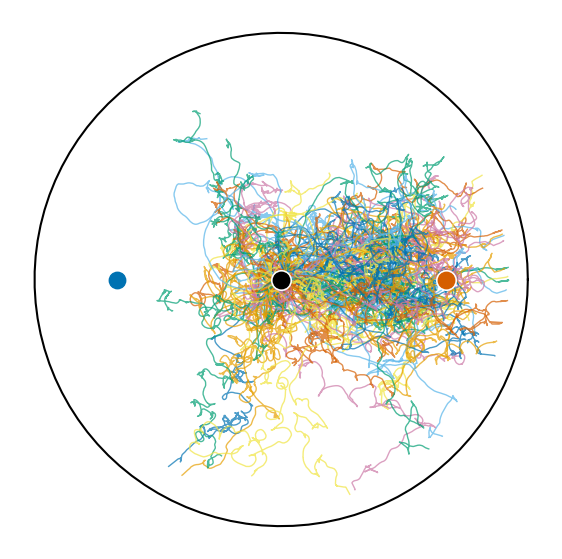

In [ ]:
an = np.linspace(0, 2 * np.pi, 100)
r = 4.5 * 10**4
dots_size = 140
dots_back_size = 200
data_num = len(use_worm_list)
fig, ax = plt.subplots(1, 1, figsize=(7, 7))
for i, worm_id in enumerate(use_worm_list):
    x = platex_frame[worm_id_frame==worm_id]
    y = platey_frame[worm_id_frame==worm_id]
    ax.plot(x, y, linewidth=1, zorder=1, color=color_palette[i%color_num], alpha=0.7)
ax.plot(r*np.cos(an), r*np.sin(an), color='k')
ax.scatter(0, 0, color='k', label='center', zorder=3, s=dots_size)
ax.scatter(30000, 0, color=red, zorder=3, s=dots_size)
ax.scatter(-30000, 0, color=blue, zorder=3, s=dots_size)
ax.scatter(0, 0, color='white', label='center', zorder=2, s=dots_back_size)
ax.scatter(30000, 0, color='white', zorder=2, s=dots_back_size)
ax.scatter(-30000, 0, color='white', zorder=2, s=dots_back_size)
ax.grid()
ax.axis('equal')
ax.axis('off')
fig.savefig(os.path.join(save_fig_dir, '1-B-track_all_worms.svg'), format="svg", transparent=True)
plt.show()

## Figure 1B right

### 1-A worm 1 (worm id: 180)

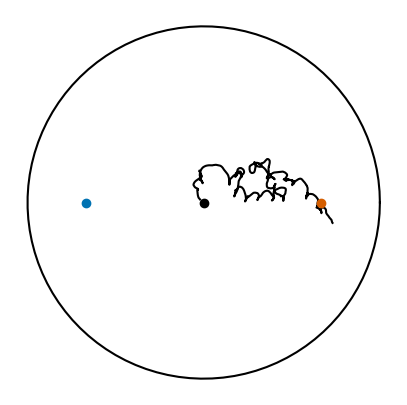

In [ ]:
an = np.linspace(0, 2 * np.pi, 100)
r = 4.5 * 10**4
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
worm_id = 180
x = platex_frame[worm_id_frame==worm_id]
y = platey_frame[worm_id_frame==worm_id]
ax.plot(x, y, color='k')
ax.plot(r*np.cos(an), r*np.sin(an), color='k')
ax.scatter(0, 0, color='k', zorder=1)
ax.scatter(30000, 0, color=red, zorder=2)
ax.scatter(-30000, 0, color=blue, zorder=2)
ax.grid()
ax.axis('equal')
ax.axis('off')
fig.savefig(os.path.join(save_fig_dir, '1-B-track_worm180.svg'), format="svg", transparent=True)
plt.show()

### 1-A worm 2 (worm id: 181)

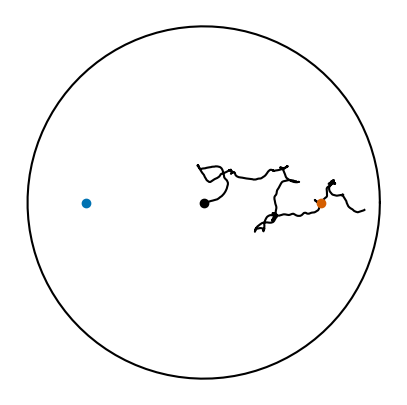

In [ ]:
an = np.linspace(0, 2 * np.pi, 100)
r = 4.5 * 10**4
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
worm_id = 181
x = platex_frame[worm_id_frame==worm_id]
y = platey_frame[worm_id_frame==worm_id]
ax.plot(x, y, color='k')
ax.plot(r*np.cos(an), r*np.sin(an), color='k')
ax.scatter(0, 0, color='k', zorder=1)
ax.scatter(30000, 0, color=red, zorder=2)
ax.scatter(-30000, 0, color=blue, zorder=2)
ax.grid()
ax.axis('equal')
ax.axis('off')
fig.savefig(os.path.join(save_fig_dir, '1-B-track_worm181.svg'), format="svg", transparent=True)
plt.show()

### 1-A worm 3 (worm id: 125)

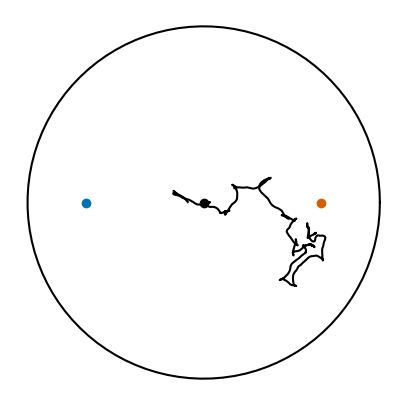

In [ ]:
an = np.linspace(0, 2 * np.pi, 100)
r = 4.5 * 10**4
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
worm_id = 125
x = platex_frame[worm_id_frame==worm_id]
y = platey_frame[worm_id_frame==worm_id]
ax.plot(x, y, color='k')
ax.plot(r*np.cos(an), r*np.sin(an), color='k')
ax.scatter(0, 0, color='k', zorder=1)
ax.scatter(30000, 0, color=red, zorder=2)
ax.scatter(-30000, 0, color=blue, zorder=2)
ax.grid()
ax.axis('equal')
ax.axis('off')
fig.savefig(os.path.join(save_fig_dir, '1-B-track_worm125.svg'), format="svg", transparent=True)
plt.show()

### 1-A worm 4 (worm id: 113)

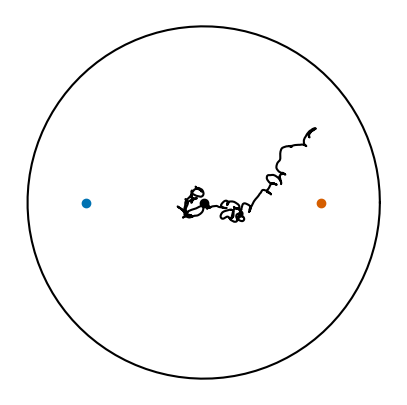

In [ ]:
an = np.linspace(0, 2 * np.pi, 100)
r = 4.5 * 10**4
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
worm_id = 113
x = platex_frame[worm_id_frame==worm_id]
y = platey_frame[worm_id_frame==worm_id]
ax.plot(x, y, color='k')
ax.plot(r*np.cos(an), r*np.sin(an), color='k')
ax.scatter(0, 0, color='k', zorder=1)
ax.scatter(30000, 0, color=red, zorder=2)
ax.scatter(-30000, 0, color=blue, zorder=2)
ax.grid()
ax.axis('equal')
ax.axis('off')
fig.savefig(os.path.join(save_fig_dir, '1-B-track_worm113.svg'), format="svg", transparent=True)
plt.show()

## Figure 2B

### Figure 2B left

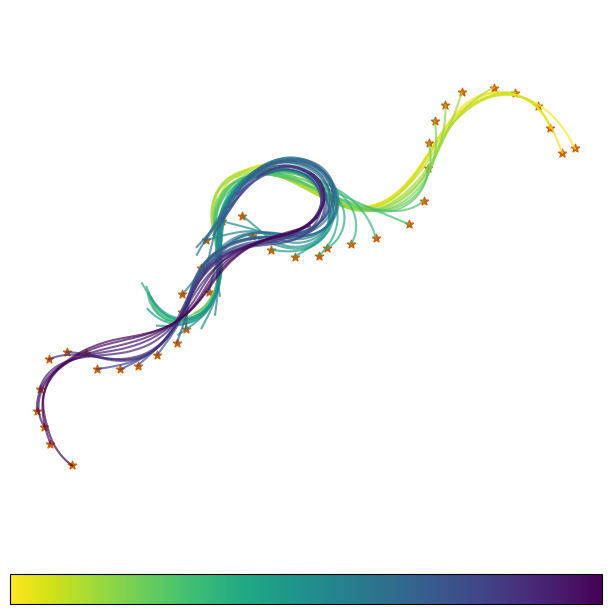

In [ ]:
block_i = np.argwhere(tOmega_FB_block==1).reshape(-1)[100]
swing_i = int(pure_after_swing_block[block_i])
frames_i = np.arange(int(start_frame_swing[int(pure_before_swing_block[block_i])]), int(end_frame_swing[int(pure_after_swing_block[block_i])]))
if len(np.unique(worm_id_frame[frames_i]))!=1:
    print('different worm')

fig, ax = plt.subplots(1, 1, figsize=(6, 6), constrained_layout=True)
frames_i_length = len(frames_i)
cmap = cm.viridis
reversed_cmap = cmap.reversed()
color_index = np.linspace(0, 1, frames_i_length)
for j in range(frames_i_length):
    idx = frames_i[j]
    ax.plot(10*(midline_real_x[idx, :]+centerx_im[idx])+platex_frame[idx],
            10*(midline_real_y[idx, :]+centery_im[idx])+platey_frame[idx], c=reversed_cmap(color_index[j]), alpha=0.7)
    plot = ax.scatter(10*(midline_real_x[idx, 0]+centerx_im[idx])+platex_frame[idx],
            10*(midline_real_y[idx, 0]+centery_im[idx])+platey_frame[idx], marker='*', color=red)
ax.axis('equal')
ax.axis('off')
norm = plt.Normalize(vmin=np.min(color_index), vmax=np.max(color_index))
sm = plt.cm.ScalarMappable(cmap=reversed_cmap, norm=norm)
sm.set_array([])
colorbar = fig.colorbar(sm, ax=ax, orientation='horizontal')
colorbar.set_ticks([])
fig.savefig(os.path.join(save_fig_dir, '2-B-posture_omega_block100_all.svg'), format="svg", transparent=True)
plt.show()

### Figure 2B right (the last swing)

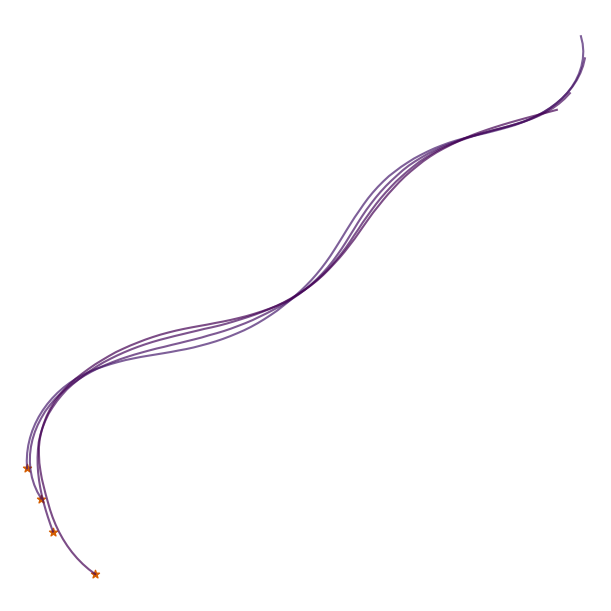

In [ ]:
block_i = np.argwhere(tOmega_FB_block==1).reshape(-1)[100]
swing_i = int(pure_after_swing_block[block_i])
frames_i = np.arange(int(start_frame_swing[int(pure_after_swing_block[block_i])]), int(end_frame_swing[int(pure_after_swing_block[block_i])]))
if len(np.unique(worm_id_frame[frames_i]))!=1:
    print('different worm')

fig, ax = plt.subplots(1, 1, figsize=(6, 6), constrained_layout=True)
frames_i_length = len(frames_i)
color_index = np.linspace(0, 1, len(np.arange(int(start_frame_swing[int(pure_before_swing_block[block_i])]), int(end_frame_swing[int(pure_after_swing_block[block_i])]))))[-frames_i_length:]
for j in range(frames_i_length):
    idx = frames_i[j]
    ax.plot(10*(midline_real_x[idx, :]+centerx_im[idx])+platex_frame[idx],
            10*(midline_real_y[idx, :]+centery_im[idx])+platey_frame[idx], c=reversed_cmap(color_index[j]), alpha=0.7)
    plot = ax.scatter(10*(midline_real_x[idx, 0]+centerx_im[idx])+platex_frame[idx],
            10*(midline_real_y[idx, 0]+centery_im[idx])+platey_frame[idx], marker='*', color=red)
ax.axis('equal')
ax.axis('off')
fig.savefig(os.path.join(save_fig_dir, '2-B-posture_omega_block100_last_swing.svg'), format="svg", transparent=True)
plt.show()

## Figure 2D

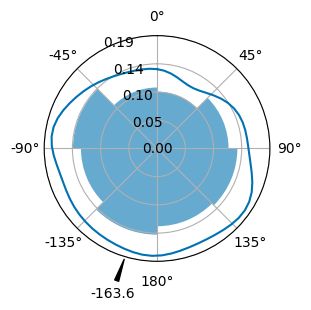

In [ ]:
bins_num = 8
bin_ends = np.linspace(0, 360, bins_num+1)
x_tick_labels = np.linspace(0, 360, bins_num+1)[:-1]
x_tick_labels[x_tick_labels>180] = x_tick_labels[x_tick_labels>180] - 360

bearing_i = before_bearing_sOmega[~np.isnan(before_bearing_sOmega)]
bearing_i[bearing_i<0] = bearing_i[bearing_i<0] + 360
fig, ax = plt.subplots(1, 1, figsize=(3, 3), constrained_layout=True, subplot_kw={'projection': 'polar'})
mean_text = np.arctan2(np.nansum(np.sin(bearing_i*np.pi/180)), np.nansum(np.cos(bearing_i*np.pi/180))) * 180/np.pi
if mean_text<0:
    mean = mean_text + 360
else:
    mean = mean_text
counts, _ = np.histogram(bearing_i, bins=bin_ends)
counts_total = len(bearing_i)
ax.bar(np.radians(bin_ends[:-1]), counts/counts_total, align='edge', width=2*np.pi/bins_num, color=blue, alpha=0.6)
# plot kernel density estimates
x, kde = vonmises_kde(np.radians(bearing_i), 15)
ax.plot(x, kde, color=blue)
ax.annotate(f'{mean_text:.1f}', xy=(np.radians(mean), ax.get_ylim()[1]*1), xytext=(np.radians(mean), ax.get_ylim()[1]*1.4),
            arrowprops=dict(facecolor='k', arrowstyle='wedge'), ha='center', va='bottom')
# setting
ax.set_theta_zero_location('N')
ax.set_theta_direction(-1)
ax.set_xticks(np.radians(bin_ends[:-1]))
ax.set_xticklabels([f"{int(b)}°" for b in x_tick_labels])
y_max_with = ax.get_ylim()[1]
new_yticks = np.linspace(0, y_max_with, 5)
ax.set_yticks(new_yticks)
ax.set_yticklabels([])
for ytick in new_yticks:
    ax.text(
        np.radians(-20), ytick,
        f"{ytick:.2f}",
        ha='center', va='center', fontsize=10, color='black'
    )
fig.savefig(os.path.join(save_fig_dir, '2-D-pre-bearing.svg'), format="svg", transparent=True)
plt.show()

## Figure 2E

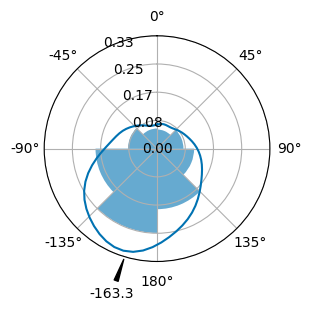

In [ ]:
bins_num = 8
bin_ends = np.linspace(0, 360, bins_num+1)
x_tick_labels = np.linspace(0, 360, bins_num+1)[:-1]
x_tick_labels[x_tick_labels>180] = x_tick_labels[x_tick_labels>180] - 360

delta_i = after_bearing_sOmega - before_bearing_sOmega
delta_i = (delta_i+180)%360 - 180
bearing_i = delta_i[~np.isnan(delta_i)]
bearing_i[bearing_i<0] = bearing_i[bearing_i<0] + 360
fig, ax = plt.subplots(1, 1, figsize=(3, 3), constrained_layout=True, subplot_kw={'projection': 'polar'})
mean_text = np.arctan2(np.nansum(np.sin(bearing_i*np.pi/180)), np.nansum(np.cos(bearing_i*np.pi/180))) * 180/np.pi
if mean_text<0:
    mean = mean_text + 360
else:
    mean = mean_text
counts, _ = np.histogram(bearing_i, bins=bin_ends)
counts_total = len(bearing_i)
ax.bar(np.radians(bin_ends[:-1]), counts/counts_total, align='edge', width=2*np.pi/bins_num, color=blue, alpha=0.6)
# plot kernel density estimates
x, kde = vonmises_kde(np.radians(bearing_i), 15)
ax.plot(x, kde, color=blue)
ax.annotate(f'{mean_text:.1f}', xy=(np.radians(mean), ax.get_ylim()[1]*1), xytext=(np.radians(mean), ax.get_ylim()[1]*1.4),
            arrowprops=dict(facecolor='k', arrowstyle='wedge'), ha='center', va='bottom')
# Settings
ax.set_theta_zero_location('N')
ax.set_theta_direction(-1)
ax.set_xticks(np.radians(bin_ends[:-1]))
ax.set_xticklabels([f"{int(b)}°" for b in x_tick_labels])
y_max = ax.get_ylim()[1]
new_yticks = np.linspace(0, y_max, 5)
ax.set_yticks(new_yticks)
ax.set_yticklabels([])
for ytick in new_yticks:
    ax.text(
        np.radians(-20), ytick,
        f"{ytick:.2f}",
        ha='center', va='center', fontsize=10, color='black'
    )
fig.savefig(os.path.join(save_fig_dir, '2-E-delta-bearing.svg'), format="svg", transparent=True)
plt.show()

## Figure 2F

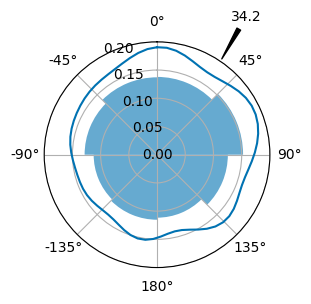

In [ ]:
bins_num = 8
bin_ends = np.linspace(0, 360, bins_num+1)
x_tick_labels = np.linspace(0, 360, bins_num+1)[:-1]
x_tick_labels[x_tick_labels>180] = x_tick_labels[x_tick_labels>180] - 360

bearing_i = after_bearing_sOmega[~np.isnan(after_bearing_sOmega)]
bearing_i[bearing_i<0] = bearing_i[bearing_i<0] + 360
fig, ax = plt.subplots(1, 1, figsize=(3, 3), constrained_layout=True, subplot_kw={'projection': 'polar'})
mean_text = np.arctan2(np.nansum(np.sin(bearing_i*np.pi/180)), np.nansum(np.cos(bearing_i*np.pi/180))) * 180/np.pi
if mean_text<0:
    mean = mean_text + 360
else:
    mean = mean_text
counts, _ = np.histogram(bearing_i, bins=bin_ends)
counts_total = len(bearing_i)
ax.bar(np.radians(bin_ends[:-1]), counts/counts_total, align='edge', width=2*np.pi/bins_num, color=blue, alpha=0.6)
# plot kernel density estimates
x, kde = vonmises_kde(np.radians(bearing_i), 15)
ax.plot(x, kde, color=blue)
ax.annotate(f'{mean_text:.1f}', xy=(np.radians(mean), ax.get_ylim()[1]*1), xytext=(np.radians(mean), ax.get_ylim()[1]*1.4),
            arrowprops=dict(facecolor='k', arrowstyle='wedge'), ha='center', va='bottom')
# Settings
ax.set_theta_zero_location('N')
ax.set_theta_direction(-1)
ax.set_xticks(np.radians(bin_ends[:-1]))
ax.set_xticklabels([f"{int(b)}°" for b in x_tick_labels])
y_max_obs = ax.get_ylim()[1]
new_yticks = np.linspace(0, y_max_obs, 5)
ax.set_yticks(new_yticks)
ax.set_yticklabels([])
for ytick in new_yticks:
    ax.text(
        np.radians(-20), ytick,
        f"{ytick:.2f}",
        ha='center', va='center', fontsize=10, color='black'
    )
fig.savefig(os.path.join(save_fig_dir, '2-F-post-bearing.svg'), format="svg", transparent=True)
plt.show()

### bearing standard deviation

In [ ]:
for i in range(3):
  if i == 0:
    print('pre-bearing')
    radians = np.radians(before_bearing_sOmega[~np.isnan(before_bearing_sOmega)])
  elif i == 1:
    print('delta-bearing')
    delta_i = after_bearing_sOmega - before_bearing_sOmega
    radians = np.radians(delta_i[~np.isnan(delta_i)])
  else:
    print('post-bearing')
    radians = np.radians(after_bearing_sOmega[~np.isnan(after_bearing_sOmega)]) # post-bearing
  x = np.cos(radians)
  y = np.sin(radians)
  mean_x = np.mean(x)
  mean_y = np.mean(y)
  mean_angle = np.degrees(np.arctan2(mean_y, mean_x))
  R = np.sqrt(mean_y**2 + mean_x**2)
  var = 1 - R
  std_dev_rad = np.sqrt(-2 * np.log(R))
  std_dev_deg = np.degrees(std_dev_rad)
  print(std_dev_deg)

pre-bearing
128.35144499847385
delta-bearing
82.01917916174135
post-bearing
133.57043453303075


## Figure 2G

mean: 162.15982859770753, var: 0.6511635996598424, std_dev: 83.15401181005342


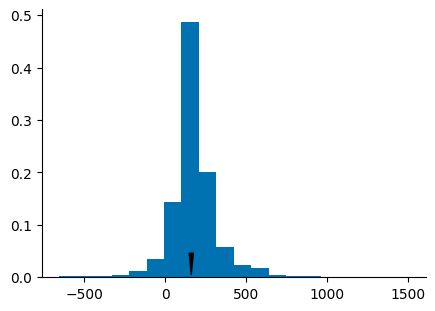

In [ ]:
before_swing_sOmega = before_swing_sOmega.astype(int)
after_swing_sOmega = after_swing_sOmega.astype(int)
peak_frame_swing = peak_frame_swing.astype(int)
start_frame_swing = start_frame_swing.astype(int)
end_frame_swing = end_frame_swing.astype(int)

sOmega_start_idx = peak_frame_swing[before_swing_sOmega]
sOmega_end_idx = peak_frame_swing[after_swing_sOmega]
sOmega_length = sOmega_end_idx - sOmega_start_idx + 1

rotation_angle = np.zeros(sOmega_num)
cum_i = 0
for query_i in range(sOmega_num):
    new_cum_i = cum_i + sOmega_length[query_i]
    temp_theta = theta_real_0[sOmega_start_idx[query_i]:sOmega_end_idx[query_i]+1, :]
    temp_theta = temp_theta[:,0:1] + np.hstack(( np.zeros((sOmega_length[query_i], 1)), \
            np.cumsum (np.mod( temp_theta[:,1:] - temp_theta[:,:-1] + np.pi, 2*np.pi) - np.pi, 1) ))
    # calculate movement vector at start peak
    swing_no = np.where(start_frame_swing <= sOmega_start_idx[query_i])[0][-1]
    assert( np.where(end_frame_swing >= sOmega_start_idx[query_i])[0][0] == swing_no )
    swing_start = start_frame_swing[swing_no]
    swing_end = end_frame_swing[swing_no]
    # sometimes these are same points, in that case take one before and one after.
    if swing_start == swing_end:
        swing_start = swing_start-1
        swing_end = swing_end+1
    swing_theta = theta_real_0[swing_start:swing_end+1,:]
    swing_theta = swing_theta[:,0:1] + np.hstack(( np.zeros((swing_end+1-swing_start, 1)), \
            np.cumsum (np.mod( swing_theta[:,1:] - swing_theta[:,:-1] + np.pi, 2*np.pi) - np.pi, 1) \
                                    ))
    mean_swing_theta = np.nanmean(swing_theta, 1)
    mean_swing_theta = mean_swing_theta[0] + np.hstack(( np.zeros(1), \
            np.cumsum (np.mod( mean_swing_theta[1:] - mean_swing_theta[:-1] + np.pi, 2*np.pi) - np.pi) \
                                    ))
    temp_theta = temp_theta - np.nanmean(mean_swing_theta) # all in radian, movement direction is x axis positive
    temp_mean = np.nanmean(temp_theta, 1).reshape(-1,1)
    temp2_mean0 = np.mod( temp_mean[0] + np.pi, 2*np.pi ) - np.pi
    temp2_mean = temp2_mean0 + \
        np.hstack(( 0, np.cumsum( np.mod( temp_mean[1:] - temp_mean[:-1] + np.pi, 2*np.pi ) - np.pi ) ))
    rotation_angle[query_i] = np.sum( np.mod( temp_mean[1:] - temp_mean[:-1] + np.pi, 2*np.pi ) - np.pi )/np.pi*180 \
                                * vd_axis_sign_frame[sOmega_start_idx[query_i]]
    cum_i = new_cum_i

radians = np.radians(rotation_angle)
x = np.cos(radians)
y = np.sin(radians)
mean_x = np.mean(x)
mean_y = np.mean(y)
mean_angle = np.degrees(np.arctan2(mean_y, mean_x))
R = np.sqrt(mean_y**2 + mean_x**2)
var = 1 - R
std_dev_rad = np.sqrt(-2 * np.log(R))
std_dev_deg = np.degrees(std_dev_rad)
print(f'mean: {mean_angle}, var: {var}, std_dev: {std_dev_deg}')

fig, ax = plt.subplots(1, 1, figsize=(3*np.sqrt(2), 3), constrained_layout=True)
bins_num = 20
ax.hist(rotation_angle, bins=bins_num, weights=np.ones(len(rotation_angle))/len(rotation_angle), color=blue)
ax.annotate(f'', xy=(mean_angle, 0), xytext=(mean_angle, ax.get_ylim()[1]*0.10),
            arrowprops=dict(facecolor='k', edgecolor='k', arrowstyle='wedge'), ha='left', va='center')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
fig.savefig(os.path.join(save_fig_dir, '2-G-rotation_angle.svg'), format="svg", transparent=True)
plt.show()

## Figure 2H

### Figure 2H center

len(before_without_swing_index): 1497


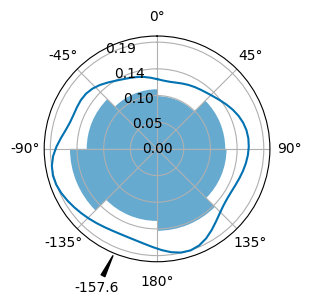

In [ ]:
bins_num = 8
bin_ends = np.linspace(0, 360, bins_num+1)
x_tick_labels = np.linspace(0, 360, bins_num+1)[:-1]
x_tick_labels[x_tick_labels>180] = x_tick_labels[x_tick_labels>180] - 360

inner_sequence_bool_swing = np.zeros(swing_num)
for i in range(sOmega_num):
    inner_sequence_bool_swing[int(before_swing_sOmega[i]):int(after_swing_sOmega[i]+1)] = 1
before_without_swing_index = np.argwhere((inner_sequence_bool_swing[:-1]==0)*(inner_sequence_bool_swing[1:]==0)*(FB_swing[:-1]==-1)*(FB_swing[1:]!=-1)).reshape(-1)
print(f'len(before_without_swing_index): {len(before_without_swing_index)}')
pre_bearing_without = bearing_swing[before_without_swing_index]
bearing_i = pre_bearing_without
bearing_i = bearing_i[~np.isnan(bearing_i)]
bearing_i[bearing_i<0] = bearing_i[bearing_i<0] + 360
fig, ax = plt.subplots(1, 1, figsize=(3, 3), constrained_layout=True, subplot_kw={'projection': 'polar'})
mean_text = np.arctan2(np.nansum(np.sin(bearing_i*np.pi/180)), np.nansum(np.cos(bearing_i*np.pi/180))) * 180/np.pi
if mean_text<0:
    mean = mean_text + 360
else:
    mean = mean_text
counts, _ = np.histogram(bearing_i, bins=bin_ends)
counts_total = len(bearing_i)
ax.bar(np.radians(bin_ends[:-1]), counts/counts_total, align='edge', width=2*np.pi/bins_num, color=blue, alpha=0.6)
# plot kernel density estimates
x, kde = vonmises_kde(np.radians(bearing_i), 15)
ax.plot(x, kde, color=blue)
ax.annotate(f'{mean_text:.1f}', xy=(np.radians(mean), ax.get_ylim()[1]*1), xytext=(np.radians(mean), ax.get_ylim()[1]*1.4),
            arrowprops=dict(facecolor='k', arrowstyle='wedge'), ha='center', va='bottom')
# setting
ax.set_theta_zero_location('N')
ax.set_theta_direction(-1)
ax.set_xticks(np.radians(bin_ends[:-1]))
ax.set_xticklabels([f"{int(b)}°" for b in x_tick_labels])
new_yticks = np.linspace(0, y_max_with, 5)
ax.set_yticks(new_yticks)
ax.set_yticklabels([])
for ytick in new_yticks:
    ax.text(
        np.radians(-20), ytick,
        f"{ytick:.2f}",
        ha='center', va='center', fontsize=10, color='black'
    )
fig.savefig(os.path.join(save_fig_dir, '2-H-center-pre-bearing_without_turns.svg'), format="svg", transparent=True)
plt.show()

### Figure 2H right

[1412 1309]


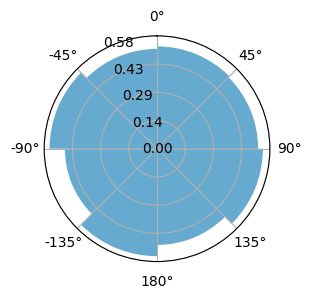

In [ ]:
pre_with = before_bearing_sOmega[~np.isnan(before_bearing_sOmega)]
pre_without = pre_bearing_without[~np.isnan(pre_bearing_without)]

def assign_bin_start0(angle_deg):
    if   0   <= angle_deg <  45:
        return 0
    elif 45  <= angle_deg <  90:
        return 1
    elif 90  <= angle_deg < 135:
        return 2
    elif 135 <= angle_deg <= 180:
        return 3
    elif -180 <= angle_deg < -135:
        return 4
    elif -135 <= angle_deg < -90:
        return 5
    elif -90  <= angle_deg < -45:
        return 6
    elif -45  <= angle_deg <  0:
        return 7

frequency_table = np.zeros((8, 2), dtype=int) # row1: with, row2: without
for angle in pre_with:
    bin_id = assign_bin_start0(angle)
    frequency_table[bin_id, 0] += 1
for angle in pre_without:
    bin_id = assign_bin_start0(angle)
    frequency_table[bin_id, 1] += 1
print(np.sum(frequency_table, axis=0))
turn_probability = frequency_table[:, 0] / (frequency_table[:, 0] + frequency_table[:, 1])

bins_num = 8
bin_ends = np.linspace(0, 360, bins_num+1)
x_tick_labels = np.linspace(0, 360, bins_num+1)[:-1]
x_tick_labels[x_tick_labels>180] = x_tick_labels[x_tick_labels>180] - 360

fig, ax = plt.subplots(1, 1, figsize=(3, 3), constrained_layout=True, subplot_kw={'projection': 'polar'})
ax.bar(np.radians(bin_ends[:-1]), turn_probability, align='edge', width=2*np.pi/bins_num, color=blue, alpha=0.6)
# setting
ax.set_theta_zero_location('N')
ax.set_theta_direction(-1)
ax.set_xticks(np.radians(bin_ends[:-1]))
ax.set_xticklabels([f"{int(b)}°" for b in x_tick_labels])
y_max_without = ax.get_ylim()[1]
new_yticks = np.linspace(0, y_max_without, 5)
ax.set_yticks(new_yticks)
ax.set_yticklabels([])
for ytick in new_yticks:
    ax.text(
        np.radians(-20), ytick,
        f"{ytick:.2f}",
        ha='center', va='center', fontsize=10, color='black'
    )
fig.savefig(os.path.join(save_fig_dir, '2-H-right-occurrence_probability.svg'), format="svg", transparent=True)
plt.show()

### chi-square test

In [ ]:
chi2, p, dof, expected = chi2_contingency(frequency_table)
print(f"chi-squared statistic: {chi2:.3f}")
print(f"degrees of freedom: {dof}")
print(f"p-value: {p:.4f}")

chi-squared statistic: 8.135
degrees of freedom: 7
p-value: 0.3209


## Figure 2I

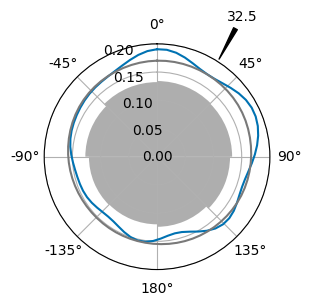

In [ ]:
bins_num = 8
bin_ends = np.linspace(0, 360, bins_num+1)
x_tick_labels = np.linspace(0, 360, bins_num+1)[:-1]
x_tick_labels[x_tick_labels>180] = x_tick_labels[x_tick_labels>180] - 360

# observed
bearing_i = after_bearing_sOmega[~np.isnan(after_bearing_sOmega)]
bearing_i[bearing_i<0] = bearing_i[bearing_i<0] + 360
fig, ax = plt.subplots(1, 1, figsize=(3, 3), constrained_layout=True, subplot_kw={'projection': 'polar'})
mean_text = np.arctan2(np.nansum(np.sin(bearing_i*np.pi/180)), np.nansum(np.cos(bearing_i*np.pi/180))) * 180/np.pi
if mean_text<0:
    mean = mean_text + 360
else:
    mean = mean_text
counts, _ = np.histogram(bearing_i, bins=bin_ends)
counts_total = len(bearing_i)
x, kde = vonmises_kde(np.radians(bearing_i), 15)
ax.plot(x, kde, color=blue)

# randomized
with open(os.path.join(data_dir, 'Figure_2J_reconstructed_post-bearing_3.pkl'), 'rb') as f:
    randomized_bAfter_list = pickle.load(f)
randomized_bAfter = np.concatenate(randomized_bAfter_list, axis=0)
bearing_i = randomized_bAfter[~np.isnan(randomized_bAfter)]
bearing_i[bearing_i<0] = bearing_i[bearing_i<0] + 360
mean_text = np.arctan2(np.nansum(np.sin(bearing_i*np.pi/180)), np.nansum(np.cos(bearing_i*np.pi/180))) * 180/np.pi
if mean_text<0:
    mean = mean_text + 360
else:
    mean = mean_text
counts, _ = np.histogram(bearing_i, bins=bin_ends)
counts_total = len(bearing_i)
ax.bar(np.radians(bin_ends[:-1]), counts/counts_total, align='edge', width=2*np.pi/bins_num, color=grey, alpha=0.6)
# plot kernel density estimates
x, kde = vonmises_kde(np.radians(bearing_i), 15)
ax.plot(x, kde, color=grey)
ax.annotate(f'{mean_text:.1f}', xy=(np.radians(mean), ax.get_ylim()[1]*1), xytext=(np.radians(mean), ax.get_ylim()[1]*1.4),
            arrowprops=dict(facecolor='k', arrowstyle='wedge'), ha='center', va='bottom')
# Settings
ax.set_theta_zero_location('N')
ax.set_theta_direction(-1)
ax.set_xticks(np.radians(bin_ends[:-1]))
ax.set_xticklabels([f"{int(b)}°" for b in x_tick_labels])
new_yticks = np.linspace(0, y_max_obs, 5)
ax.set_yticks(new_yticks)
ax.set_yticklabels([])
for ytick in new_yticks:
    ax.text(
        np.radians(-20), ytick,
        f"{ytick:.2f}",
        ha='center', va='center', fontsize=10, color='black'
    )
fig.savefig(os.path.join(save_fig_dir, '2-I-reconstructed_post-bearing.svg'), format="svg", transparent=True)
plt.show()

## Figure 2J

### Re-running Analysis with New Random Data



```
sampling_num = 1000
bins_num = 8
bin_ends = np.linspace(-180, 180, bins_num+1)
bBefore_back = forward_before_backward_bearing_sOmega[~np.isnan(forward_before_backward_bearing_sOmega)]
bBefore = before_bearing_sOmega
bAfter = after_bearing_sOmega
bDelta = bAfter - bBefore
bDelta = (bDelta+180)%360 - 180
bAfter = bAfter[~np.isnan(bAfter)]

randomized_bAfter = np.array([])
randomized_bAfter_list = []
randomized_p = []
for i in range(sampling_num):
    shuffled_id = list(np.arange(len(bBefore)))
    random.shuffle(shuffled_id)
    not_nan_idx_i = np.argwhere((~np.isnan(bBefore))*(~np.isnan(bDelta[np.array(shuffled_id)]))).reshape(-1)
    randomized_bAfter_i = bBefore + bDelta[np.array(shuffled_id)]
    randomized_bAfter_i = randomized_bAfter_i[not_nan_idx_i]
    randomized_bAfter_i = (randomized_bAfter_i+180)%(360) - 180
    randomized_bAfter_i = randomized_bAfter_i[~np.isnan(randomized_bAfter_i)]
    randomized_bAfter = np.concatenate([randomized_bAfter, randomized_bAfter_i], axis=0)
    randomized_bAfter_list.append(randomized_bAfter_i)
    rand_p_i = np.mean(np.cos(np.deg2rad(randomized_bAfter_i)))
    randomized_p.append(rand_p_i)
randomized_p = np.array(randomized_p)
obs_p = np.mean(np.cos(np.deg2rad(bAfter)))
rand_mean = np.mean(randomized_p)
rand_std = np.std(randomized_p, ddof=1)
rand_error = rand_std / np.sqrt(len(randomized_p))
z = (obs_p - rand_mean) / rand_std
permu_p = stats.norm.cdf(z)
if permu_p>0.5:
    permu_p = 1 - permu_p
print(f'rand_mean: {rand_mean}, rand_std: {rand_std}, z: {z}, permu_p: {permu_p}')

with open(os.path.join(data_dir, 'Figure_2J_reconstructed_post-bearing_3.pkl'), 'wb') as f:
    pickle.dump(randomized_bAfter_list, f)

df = pd.DataFrame({
    'rand_good': randomized_p
})
fig, ax = plt.subplots(1, 1, figsize=(3/np.sqrt(3), 3), constrained_layout=True)
sns.kdeplot(data=df, y='rand_good', ax=ax, clip_on=False, fill=True, alpha=0.6, linewidth=0, color=grey)
ax.annotate(f'', xy=(0, obs_p), xytext=(ax.get_xlim()[1]*0.25, obs_p),
            arrowprops=dict(facecolor=blue, edgecolor=blue, arrowstyle='wedge'), ha='left', va='center') # observed
ax.annotate(f'', xy=(0, rand_mean), xytext=(ax.get_xlim()[1]*0.25, rand_mean),
            arrowprops=dict(facecolor='#555555', edgecolor='#555555', arrowstyle='wedge'), ha='left', va='center') # randomized
ax.set_xlabel('')
ax.set_ylabel('')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
fig.savefig(os.path.join(save_fig_dir, '2-J-mean-cos(post-bearing).svg'), format="svg", transparent=True)
plt.show()
```



### Re-running Analysis with Figure Data

rand_mean: 0.02474478137699743, rand_std: 0.016684202332923847, z: 1.7928585759828743, permu_p: 0.03649777021603817


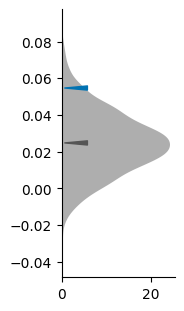

In [ ]:
with open(os.path.join(data_dir, 'Figure_2J_reconstructed_post-bearing_3.pkl'), 'rb') as f:
    randomized_bAfter_list = pickle.load(f)
randomized_bAfter = np.concatenate(randomized_bAfter_list, axis=0)

sampling_num = 1000
bBefore = before_bearing_sOmega
bAfter = after_bearing_sOmega
bDelta = bAfter - bBefore
bDelta = (bDelta+180)%360 - 180
bAfter = bAfter[~np.isnan(bAfter)]

randomized_p = [
    np.mean(np.cos(np.deg2rad(b))) for b in randomized_bAfter_list
]
randomized_p = np.array(randomized_p)
obs_p = np.mean(np.cos(np.deg2rad(bAfter)))
rand_mean = np.mean(randomized_p)
rand_std = np.std(randomized_p, ddof=1)
rand_error = rand_std / np.sqrt(len(randomized_p))
z = (obs_p - rand_mean) / rand_std
permu_p = stats.norm.cdf(z)
if permu_p>0.5:
    permu_p = 1 - permu_p
print(f'rand_mean: {rand_mean}, rand_std: {rand_std}, z: {z}, permu_p: {permu_p}')

df = pd.DataFrame({
    'rand_good': randomized_p
})
fig, ax = plt.subplots(1, 1, figsize=(3/np.sqrt(3), 3), constrained_layout=True)
sns.kdeplot(data=df, y='rand_good', ax=ax, clip_on=False, fill=True, alpha=0.6, linewidth=0, color=grey)
ax.annotate(f'', xy=(0, obs_p), xytext=(ax.get_xlim()[1]*0.25, obs_p),
            arrowprops=dict(facecolor=blue, edgecolor=blue, arrowstyle='wedge'), ha='left', va='center') # observed
ax.annotate(f'', xy=(0, rand_mean), xytext=(ax.get_xlim()[1]*0.25, rand_mean),
            arrowprops=dict(facecolor='#555555', edgecolor='#555555', arrowstyle='wedge'), ha='left', va='center') # randomized
ax.set_xlabel('')
ax.set_ylabel('')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
fig.savefig(os.path.join(save_fig_dir, '2-J-mean-cos(post-bearing).svg'), format="svg", transparent=True)
plt.show()

## Figure 3A right

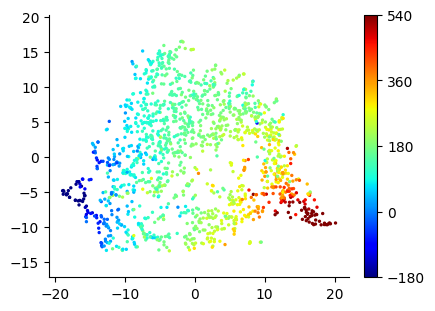

In [ ]:
with open(os.path.join(data_dir, 'embedding_results_20241101.pkl'), 'rb') as f:
    s_theta_flat, TSNE_embedded , TSNE_PC, UMAP_embedded, UMAP_PC = pickle.load(f)

scaled_rotation_angle = (rotation_angle-180)/360 # rotation angle is calculated in codes for Figure 2G
scaled_rotation_angle[scaled_rotation_angle > 1] = 1
scaled_rotation_angle[scaled_rotation_angle < -1] = -1

colorbar_ticklabels = [-180, 0, 180, 360, 540]
fig, ax = plt.subplots(1, 1, figsize=(3*np.sqrt(2), 3), constrained_layout=True)
plot_data1 = TSNE_PC[:, 0]
plot_data2 = TSNE_PC[:, 1]
plt.scatter(plot_data1, plot_data2, marker="o", s=2, vmin=-1, vmax=1,
            c=scaled_rotation_angle, cmap='jet')
ax.axis('equal')
ax.set_xlim(ax.get_xlim()[0], ax.get_xlim()[1])

norm = plt.Normalize(vmin=colorbar_ticklabels[0], vmax=colorbar_ticklabels[-1])
sm = plt.cm.ScalarMappable(cmap='jet', norm=norm)
sm.set_array([])
colorbar = fig.colorbar(sm, ax=ax, orientation='vertical')
colorbar.set_ticks(colorbar_ticklabels)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
fig.savefig(os.path.join(save_fig_dir, '3-A-t-SNE_map_colored_by_rotation_angle.svg'), format="svg", transparent=True)
plt.show()

## Figure 3B-F

### Posture per frame

In [ ]:
with open(os.path.join(data_dir, 'kmeans_demonstration_dataset_20241101.pkl'), 'rb') as f:
    dicts = pickle.load(f)
kmean_cluster_assignments = dicts[0]['kmean_cluster_assignments']
n_cluster_members = dicts[0]['n_cluster_members']
theta_flat = dicts[0]['theta_flat']
kmeans = dicts[0]['kmeans']
centers = kmeans.cluster_centers_

for i in range(5):
    sequence_group_i = group_index[i]
    assignments_i = kmean_cluster_assignments[group_sOmega==sequence_group_i]
    count = Counter(assignments_i)
    most_common_cluster, count_of_most_common = count.most_common(1)[0]
    print(f'------------ sequence group {sequence_group_i}, {group_names[i]}, most common cluster: {most_common_cluster}, count: {count_of_most_common}/{n_cluster_members[most_common_cluster]}')

    idx_i = np.argwhere((group_sOmega==sequence_group_i)*(kmean_cluster_assignments==most_common_cluster)).reshape(-1)
    theta_flat_i = theta_flat[idx_i]
    distances = np.linalg.norm(theta_flat_i - centers[most_common_cluster], axis=1)
    if i == 4:
      closest_data_point = np.argsort(distances)[1]
    else:
      closest_data_point = np.nanargmin(distances)

    block_i = idx_i[closest_data_point]
    swing_i = int(after_swing_sOmega[block_i])
    frames_i = np.arange(int(start_frame_swing[int(before_swing_sOmega[block_i])]), int(end_frame_swing[int(after_swing_sOmega[block_i])]))
    if len(np.unique(worm_id_frame[frames_i]))!=1:
        print('different worm')

    frames_i_length = len(frames_i)
    color_index = np.linspace(0, 1, frames_i_length)[::-1]
    mean_theta_0 = mean_theta[frames_i[0]]
    midline_real_x_i = midline_real_x[frames_i]
    midline_real_y_i = midline_real_y[frames_i]
    centerx_i = centerx_im[frames_i]
    centery_i = centery_im[frames_i]
    platex_i = platex_frame[frames_i]
    platey_i = platey_frame[frames_i]

    all_midx = []
    all_midy = []
    for j in range(frames_i_length):
        midx_j = 10 * (midline_real_x_i[j, :] + centerx_i[j]) + platex_i[j]
        midy_j = 10 * (midline_real_y_i[j, :] + centery_i[j]) + platey_i[j]
        all_midx.extend(midx_j)
        all_midy.extend(midy_j)
    Gx = np.mean(all_midx)
    Gy = np.mean(all_midy)
    x_len_max = np.max(np.max(all_midx)-np.min(all_midx))
    y_len_max = np.max(np.max(all_midy)-np.min(all_midy))
    for j in range(frames_i_length):
        print(f'{j+1}/{frames_i_length}')
        fig, ax = plt.subplots(1, 1, figsize=(3, 3), constrained_layout=True)
        midx_j = 10 * (midline_real_x_i[j, :] + centerx_i[j]) + platex_i[j]
        midy_j = 10 * (midline_real_y_i[j, :] + centery_i[j]) + platey_i[j]
        midx_centered = midx_j - Gx
        midy_centered = midy_j - Gy
        midx_rotated = midx_centered * np.cos(-mean_theta_0) - midy_centered * np.sin(-mean_theta_0)
        midy_rotated = midx_centered * np.sin(-mean_theta_0) + midy_centered * np.cos(-mean_theta_0)
        midx_new = midx_rotated
        midy_new = midy_rotated
        ax.plot(midx_new, midy_new, c=cm.viridis(color_index[j]), alpha=0.7)
        ax.scatter(midx_new[0], midy_new[0], marker='*', color='red')
        ax.axis('equal')
        ax.axis('off')
        x_center = (ax.get_xlim()[1] - ax.get_xlim()[0])/2 + ax.get_xlim()[0]
        y_center = (ax.get_ylim()[1] - ax.get_ylim()[0])/2 + ax.get_ylim()[0]
        ax.set_xlim(x_center-x_len_max/2, x_center+x_len_max/2)
        ax.set_ylim(y_center-y_len_max/2, y_center+y_len_max/2)
        fig.patch.set_alpha(0)
        ax.set_facecolor((0, 0, 0, 0))
        buf = BytesIO()
        fig.savefig(buf, format='png', transparent=True, bbox_inches='tight', dpi=150)
        buf.seek(0)
        display(Image(data=buf.read()))
        buf.close()
        plt.close(fig)

Output hidden; open in https://colab.research.google.com to view.

### Figure 3B&D

sequence group 1, F, most common cluster: 9, count: 61/62


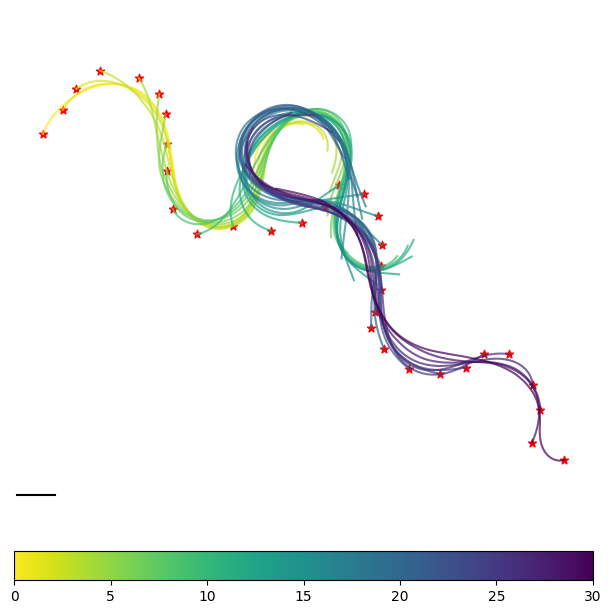

sequence group 3, B, most common cluster: 21, count: 14/22


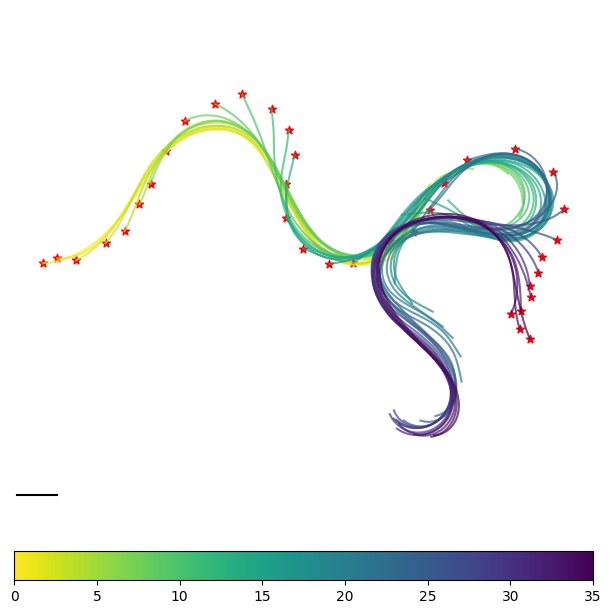

In [ ]:
for i in range(5):
    if (i != 0) and (i != 2):
      continue
    sequence_group_i = group_index[i]
    assignments_i = kmean_cluster_assignments[group_sOmega==sequence_group_i]
    count = Counter(assignments_i)
    most_common_cluster, count_of_most_common = count.most_common(1)[0]
    print(f'sequence group {sequence_group_i}, {group_names[i]}, most common cluster: {most_common_cluster}, count: {count_of_most_common}/{n_cluster_members[most_common_cluster]}')

    idx_i = np.argwhere((group_sOmega==sequence_group_i)*(kmean_cluster_assignments==most_common_cluster)).reshape(-1)
    theta_flat_i = theta_flat[idx_i]
    distances = np.linalg.norm(theta_flat_i - centers[most_common_cluster], axis=1)
    closest_data_point = np.nanargmin(distances)

    block_i = idx_i[closest_data_point]
    swing_i = int(after_swing_sOmega[block_i])
    frames_i = np.arange(int(start_frame_swing[int(before_swing_sOmega[block_i])]), int(end_frame_swing[int(after_swing_sOmega[block_i])]))
    if len(np.unique(worm_id_frame[frames_i]))!=1:
        print('different worm')

    frames_i_length = len(frames_i)
    color_index = np.linspace(0, 1, frames_i_length)[::-1]
    mean_theta_0 = mean_theta[frames_i[0]]
    midline_real_x_i = midline_real_x[frames_i]
    midline_real_y_i = midline_real_y[frames_i]
    centerx_i = centerx_im[frames_i]
    centery_i = centery_im[frames_i]
    platex_i = platex_frame[frames_i]
    platey_i = platey_frame[frames_i]

    all_midx = []
    all_midy = []
    for j in range(frames_i_length):
        midx_j = 10 * (midline_real_x_i[j, :] + centerx_i[j]) + platex_i[j]
        midy_j = 10 * (midline_real_y_i[j, :] + centery_i[j]) + platey_i[j]
        all_midx.extend(midx_j)
        all_midy.extend(midy_j)
    Gx = np.mean(all_midx)
    Gy = np.mean(all_midy)
    colorbar_ticklabels = np.arange(0, frames_i_length, 5)
    fig, ax = plt.subplots(1, 1, figsize=(6, 6), constrained_layout=True)
    for j in range(frames_i_length):
        midx_j = 10 * (midline_real_x_i[j, :] + centerx_i[j]) + platex_i[j]
        midy_j = 10 * (midline_real_y_i[j, :] + centery_i[j]) + platey_i[j]
        midx_centered = midx_j - Gx
        midy_centered = midy_j - Gy
        midx_rotated = midx_centered * np.cos(-mean_theta_0) - midy_centered * np.sin(-mean_theta_0)
        midy_rotated = midx_centered * np.sin(-mean_theta_0) + midy_centered * np.cos(-mean_theta_0)
        midx_new = midx_rotated
        midy_new = midy_rotated
        ax.plot(midx_new, midy_new, c=cm.viridis(color_index[j]), alpha=0.7)
        ax.scatter(midx_new[0], midy_new[0], marker='*', color='red')
    # others
    ax.axis('equal')
    x_min = ax.get_xlim()[0]
    x_max = ax.get_xlim()[1]
    x_len = x_max - x_min
    y_min = ax.get_ylim()[0]
    y_max = ax.get_ylim()[1]
    y_len = y_max - y_min
    if x_len > y_len:
        add_len = (x_len - y_len)/2
        ax.set_ylim([y_min-add_len, y_max+add_len])
        ax.set_xlim([x_min, x_max])
    elif x_len < y_len:
        add_len = (y_len - x_len)/2
        ax.set_xlim([x_min-add_len, x_max+add_len])
        ax.set_ylim([y_min, y_max])
    # colorbar
    norm = plt.Normalize(vmin=colorbar_ticklabels[0], vmax=colorbar_ticklabels[-1])
    sm = plt.cm.ScalarMappable(cmap='viridis_r', norm=norm)
    sm.set_array([])
    colorbar = fig.colorbar(sm, ax=ax, orientation='horizontal')
    colorbar.set_ticks(colorbar_ticklabels)
    # scale
    x_min = ax.get_xlim()[0]
    x_max = ax.get_xlim()[1]
    x_len = x_max - x_min
    y_min = ax.get_ylim()[0]
    y_max = ax.get_ylim()[1]
    y_len = y_max - y_min
    ax.plot([x_min, x_min+100], [y_min+y_len/10, y_min+y_len/10], color='k')
    ax.axis('off')
    if i == 0:
      fig.savefig(os.path.join(save_fig_dir, f'3-B-F.svg'), format="svg", transparent=True)
    elif i == 2:
      fig.savefig(os.path.join(save_fig_dir, f'3-D-B.svg'), format="svg", transparent=True)
    plt.show()

### Figure 3C

sequence group 5, BF, most common cluster: 7, count: 13/14


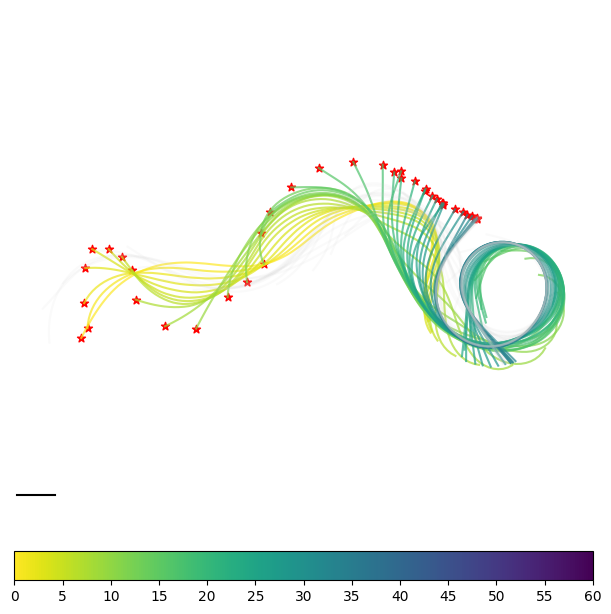

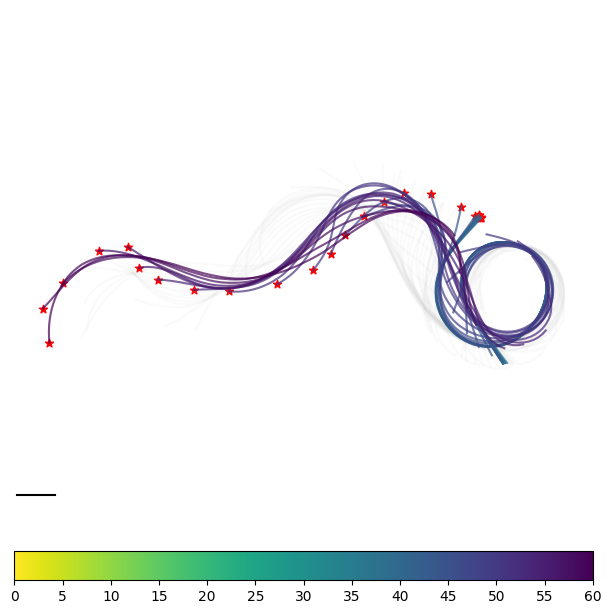

In [ ]:
i = 1
sequence_group_i = group_index[i]
assignments_i = kmean_cluster_assignments[group_sOmega==sequence_group_i]
count = Counter(assignments_i)
most_common_cluster, count_of_most_common = count.most_common(1)[0]
print(f'sequence group {sequence_group_i}, {group_names[i]}, most common cluster: {most_common_cluster}, count: {count_of_most_common}/{n_cluster_members[most_common_cluster]}')

idx_i = np.argwhere((group_sOmega==sequence_group_i)*(kmean_cluster_assignments==most_common_cluster)).reshape(-1)
theta_flat_i = theta_flat[idx_i]
distances = np.linalg.norm(theta_flat_i - centers[most_common_cluster], axis=1)
closest_data_point = np.nanargmin(distances)

block_i = idx_i[closest_data_point]
swing_i = int(after_swing_sOmega[block_i])
frames_i = np.arange(int(start_frame_swing[int(before_swing_sOmega[block_i])]), int(end_frame_swing[int(after_swing_sOmega[block_i])]))
if len(np.unique(worm_id_frame[frames_i]))!=1:
    print('different worm')
boundary_frame = 38

frames_i_length = len(frames_i)
color_index = np.linspace(0, 1, frames_i_length)[::-1]
mean_theta_0 = mean_theta[frames_i[0]]
midline_real_x_i = midline_real_x[frames_i]
midline_real_y_i = midline_real_y[frames_i]
centerx_i = centerx_im[frames_i]
centery_i = centery_im[frames_i]
platex_i = platex_frame[frames_i]
platey_i = platey_frame[frames_i]

all_midx = []
all_midy = []
for j in range(frames_i_length):
    midx_j = 10 * (midline_real_x_i[j, :] + centerx_i[j]) + platex_i[j]
    midy_j = 10 * (midline_real_y_i[j, :] + centery_i[j]) + platey_i[j]
    all_midx.extend(midx_j)
    all_midy.extend(midy_j)
Gx = np.mean(all_midx)
Gy = np.mean(all_midy)
colorbar_ticklabels = np.arange(0, frames_i_length, 5)
for k in range(2):
    fig, ax = plt.subplots(1, 1, figsize=(6, 6), constrained_layout=True)
    for j in range(frames_i_length):
        midx_j = 10 * (midline_real_x_i[j, :] + centerx_i[j]) + platex_i[j]
        midy_j = 10 * (midline_real_y_i[j, :] + centery_i[j]) + platey_i[j]
        midx_centered = midx_j - Gx
        midy_centered = midy_j - Gy
        midx_rotated = midx_centered * np.cos(-mean_theta_0) - midy_centered * np.sin(-mean_theta_0)
        midy_rotated = midx_centered * np.sin(-mean_theta_0) + midy_centered * np.cos(-mean_theta_0)
        midx_new = midx_rotated
        midy_new = midy_rotated
        if k==0:
            if j<boundary_frame:
                ax.plot(midx_new, midy_new, c=cm.viridis(color_index[j]), alpha=0.7)
                ax.scatter(midx_new[0], midy_new[0], marker='*', color='red')
            else:
                ax.plot(midx_new, midy_new, c=light_grey, alpha=0.1)
        elif k==1:
            if j>boundary_frame:
                ax.plot(midx_new, midy_new, c=cm.viridis(color_index[j]), alpha=0.7)
                ax.scatter(midx_new[0], midy_new[0], marker='*', color='red')
            else:
                ax.plot(midx_new, midy_new, c=light_grey, alpha=0.1)
    # others
    ax.axis('equal')
    x_min = ax.get_xlim()[0]
    x_max = ax.get_xlim()[1]
    x_len = x_max - x_min
    y_min = ax.get_ylim()[0]
    y_max = ax.get_ylim()[1]
    y_len = y_max - y_min
    if x_len > y_len:
        add_len = (x_len - y_len)/2
        ax.set_ylim([y_min-add_len, y_max+add_len])
        ax.set_xlim([x_min, x_max])
    elif x_len < y_len:
        add_len = (y_len - x_len)/2
        ax.set_xlim([x_min-add_len, x_max+add_len])
        ax.set_ylim([y_min, y_max])
    # colorbar
    norm = plt.Normalize(vmin=colorbar_ticklabels[0], vmax=colorbar_ticklabels[-1])
    sm = plt.cm.ScalarMappable(cmap='viridis_r', norm=norm)
    sm.set_array([])
    colorbar = fig.colorbar(sm, ax=ax, orientation='horizontal')
    colorbar.set_ticks(colorbar_ticklabels)
    # scale
    x_min = ax.get_xlim()[0]
    x_max = ax.get_xlim()[1]
    x_len = x_max - x_min
    y_min = ax.get_ylim()[0]
    y_max = ax.get_ylim()[1]
    y_len = y_max - y_min
    ax.plot([x_min, x_min+100], [y_min+y_len/10, y_min+y_len/10], color='k')
    ax.axis('off')
    fig.savefig(os.path.join(save_fig_dir, f'3-C-BF_{k+1}.svg'), format="svg", transparent=True)
    plt.show()

## Figure 3E

sequence group 2, B to F, most common cluster: 36, count: 16/32


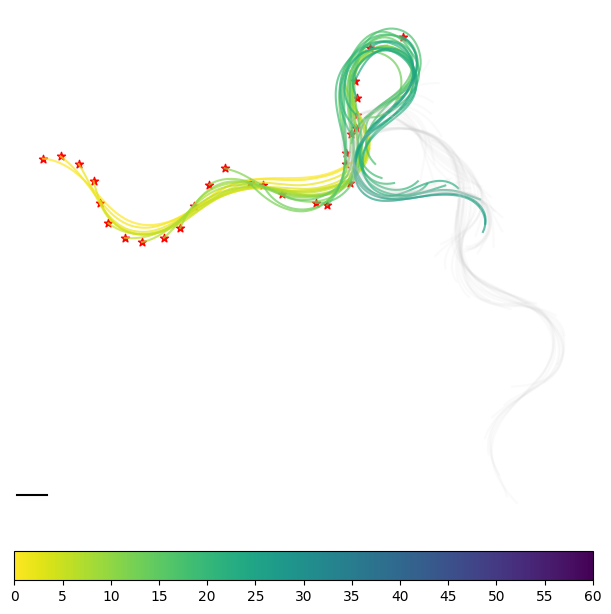

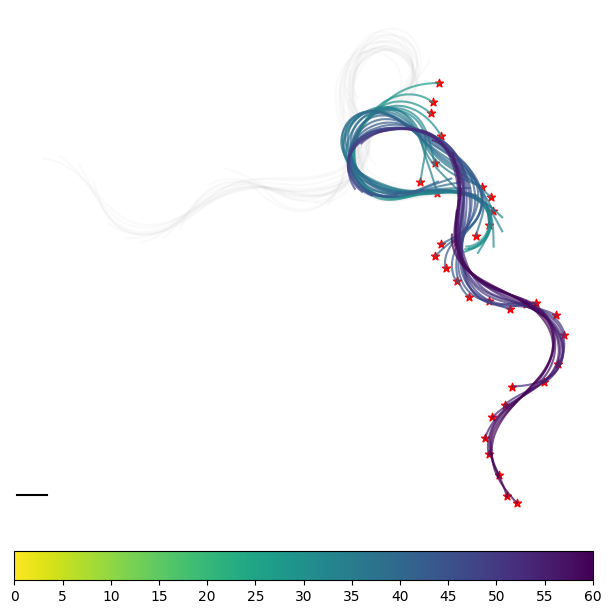

In [ ]:
i = 3
sequence_group_i = group_index[i]
assignments_i = kmean_cluster_assignments[group_sOmega==sequence_group_i]
count = Counter(assignments_i)
most_common_cluster, count_of_most_common = count.most_common(1)[0]
print(f'sequence group {sequence_group_i}, {group_names[i]}, most common cluster: {most_common_cluster}, count: {count_of_most_common}/{n_cluster_members[most_common_cluster]}')

idx_i = np.argwhere((group_sOmega==sequence_group_i)*(kmean_cluster_assignments==most_common_cluster)).reshape(-1)
theta_flat_i = theta_flat[idx_i]
distances = np.linalg.norm(theta_flat_i - centers[most_common_cluster], axis=1)
closest_data_point = np.nanargmin(distances)

block_i = idx_i[closest_data_point]
swing_i = int(after_swing_sOmega[block_i])
frames_i = np.arange(int(start_frame_swing[int(before_swing_sOmega[block_i])]), int(end_frame_swing[int(after_swing_sOmega[block_i])]))
if len(np.unique(worm_id_frame[frames_i]))!=1:
    print('different worm')
boundary_frame = 28

frames_i_length = len(frames_i)
color_index = np.linspace(0, 1, frames_i_length)[::-1]
mean_theta_0 = mean_theta[frames_i[0]]
midline_real_x_i = midline_real_x[frames_i]
midline_real_y_i = midline_real_y[frames_i]
centerx_i = centerx_im[frames_i]
centery_i = centery_im[frames_i]
platex_i = platex_frame[frames_i]
platey_i = platey_frame[frames_i]

all_midx = []
all_midy = []
for j in range(frames_i_length):
    midx_j = 10 * (midline_real_x_i[j, :] + centerx_i[j]) + platex_i[j]
    midy_j = 10 * (midline_real_y_i[j, :] + centery_i[j]) + platey_i[j]
    all_midx.extend(midx_j)
    all_midy.extend(midy_j)
Gx = np.mean(all_midx)
Gy = np.mean(all_midy)
colorbar_ticklabels = np.arange(0, frames_i_length, 5)
for k in range(2):
    fig, ax = plt.subplots(1, 1, figsize=(6, 6), constrained_layout=True)
    for j in range(frames_i_length):
        midx_j = 10 * (midline_real_x_i[j, :] + centerx_i[j]) + platex_i[j]
        midy_j = 10 * (midline_real_y_i[j, :] + centery_i[j]) + platey_i[j]
        midx_centered = midx_j - Gx
        midy_centered = midy_j - Gy
        midx_rotated = midx_centered * np.cos(-mean_theta_0) - midy_centered * np.sin(-mean_theta_0)
        midy_rotated = midx_centered * np.sin(-mean_theta_0) + midy_centered * np.cos(-mean_theta_0)
        midx_new = midx_rotated
        midy_new = midy_rotated
        if k==0:
            if j<boundary_frame:
                ax.plot(midx_new, midy_new, c=cm.viridis(color_index[j]), alpha=0.7)
                ax.scatter(midx_new[0], midy_new[0], marker='*', color='red')
            else:
                ax.plot(midx_new, midy_new, c=light_grey, alpha=0.1)
        elif k==1:
            if j>boundary_frame:
                ax.plot(midx_new, midy_new, c=cm.viridis(color_index[j]), alpha=0.7)
                ax.scatter(midx_new[0], midy_new[0], marker='*', color='red')
            else:
                ax.plot(midx_new, midy_new, c=light_grey, alpha=0.1)
    # others
    ax.axis('equal')
    x_min = ax.get_xlim()[0]
    x_max = ax.get_xlim()[1]
    x_len = x_max - x_min
    y_min = ax.get_ylim()[0]
    y_max = ax.get_ylim()[1]
    y_len = y_max - y_min
    if x_len > y_len:
        add_len = (x_len - y_len)/2
        ax.set_ylim([y_min-add_len, y_max+add_len])
        ax.set_xlim([x_min, x_max])
    elif x_len < y_len:
        add_len = (y_len - x_len)/2
        ax.set_xlim([x_min-add_len, x_max+add_len])
        ax.set_ylim([y_min, y_max])
    # colorbar
    norm = plt.Normalize(vmin=colorbar_ticklabels[0], vmax=colorbar_ticklabels[-1])
    sm = plt.cm.ScalarMappable(cmap='viridis_r', norm=norm)
    sm.set_array([])
    colorbar = fig.colorbar(sm, ax=ax, orientation='horizontal')
    colorbar.set_ticks(colorbar_ticklabels)
    # scale
    x_min = ax.get_xlim()[0]
    x_max = ax.get_xlim()[1]
    x_len = x_max - x_min
    y_min = ax.get_ylim()[0]
    y_max = ax.get_ylim()[1]
    y_len = y_max - y_min
    ax.plot([x_min, x_min+100], [y_min+y_len/10, y_min+y_len/10], color='k')
    ax.axis('off')
    fig.savefig(os.path.join(save_fig_dir, f'3-E-B_to_F_{k+1}.svg'), format="svg", transparent=True)
    plt.show()

## Figure 3F

sequence group 4, F to F, most common cluster: 31, count: 9/16


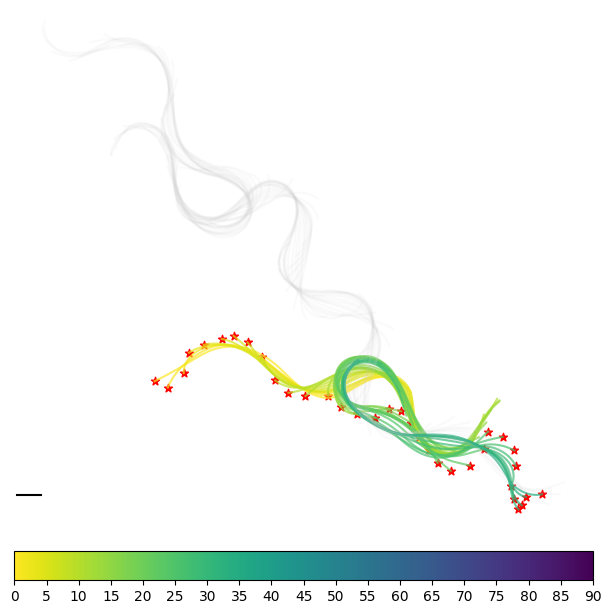

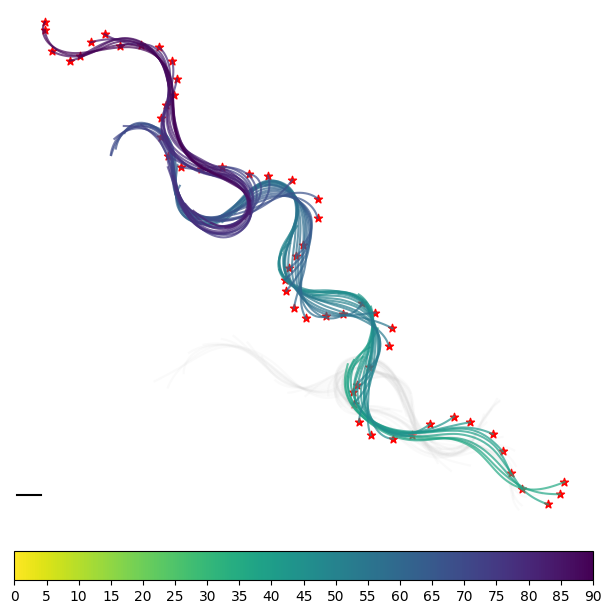

In [ ]:
i = 4
sequence_group_i = group_index[i]
assignments_i = kmean_cluster_assignments[group_sOmega==sequence_group_i]
count = Counter(assignments_i)
most_common_cluster, count_of_most_common = count.most_common(1)[0]
print(f'sequence group {sequence_group_i}, {group_names[i]}, most common cluster: {most_common_cluster}, count: {count_of_most_common}/{n_cluster_members[most_common_cluster]}')

idx_i = np.argwhere((group_sOmega==sequence_group_i)*(kmean_cluster_assignments==most_common_cluster)).reshape(-1)
theta_flat_i = theta_flat[idx_i]
distances = np.linalg.norm(theta_flat_i - centers[most_common_cluster], axis=1)
closest_data_point = np.argsort(distances)[1]

block_i = idx_i[closest_data_point]
swing_i = int(after_swing_sOmega[block_i])
frames_i = np.arange(int(start_frame_swing[int(before_swing_sOmega[block_i])]), int(end_frame_swing[int(after_swing_sOmega[block_i])]))
if len(np.unique(worm_id_frame[frames_i]))!=1:
    print('different worm')
boundary_frame = 35

frames_i_length = len(frames_i)
color_index = np.linspace(0, 1, frames_i_length)[::-1]
mean_theta_0 = mean_theta[frames_i[0]]
midline_real_x_i = midline_real_x[frames_i]
midline_real_y_i = midline_real_y[frames_i]
centerx_i = centerx_im[frames_i]
centery_i = centery_im[frames_i]
platex_i = platex_frame[frames_i]
platey_i = platey_frame[frames_i]

all_midx = []
all_midy = []
for j in range(frames_i_length):
    midx_j = 10 * (midline_real_x_i[j, :] + centerx_i[j]) + platex_i[j]
    midy_j = 10 * (midline_real_y_i[j, :] + centery_i[j]) + platey_i[j]
    all_midx.extend(midx_j)
    all_midy.extend(midy_j)
Gx = np.mean(all_midx)
Gy = np.mean(all_midy)
colorbar_ticklabels = np.arange(0, frames_i_length, 5)
for k in range(2):
    fig, ax = plt.subplots(1, 1, figsize=(6, 6), constrained_layout=True)
    for j in range(frames_i_length):
        midx_j = 10 * (midline_real_x_i[j, :] + centerx_i[j]) + platex_i[j]
        midy_j = 10 * (midline_real_y_i[j, :] + centery_i[j]) + platey_i[j]
        midx_centered = midx_j - Gx
        midy_centered = midy_j - Gy
        midx_rotated = midx_centered * np.cos(-mean_theta_0) - midy_centered * np.sin(-mean_theta_0)
        midy_rotated = midx_centered * np.sin(-mean_theta_0) + midy_centered * np.cos(-mean_theta_0)
        midx_new = midx_rotated
        midy_new = midy_rotated
        if k==0:
            if j<boundary_frame:
                ax.plot(midx_new, midy_new, c=cm.viridis(color_index[j]), alpha=0.7)
                ax.scatter(midx_new[0], midy_new[0], marker='*', color='red')
            else:
                ax.plot(midx_new, midy_new, c=light_grey, alpha=0.1)
        elif k==1:
            if j>boundary_frame:
                ax.plot(midx_new, midy_new, c=cm.viridis(color_index[j]), alpha=0.7)
                ax.scatter(midx_new[0], midy_new[0], marker='*', color='red')
            else:
                ax.plot(midx_new, midy_new, c=light_grey, alpha=0.1)
    # others
    ax.axis('equal')
    x_min = ax.get_xlim()[0]
    x_max = ax.get_xlim()[1]
    x_len = x_max - x_min
    y_min = ax.get_ylim()[0]
    y_max = ax.get_ylim()[1]
    y_len = y_max - y_min
    if x_len > y_len:
        add_len = (x_len - y_len)/2
        ax.set_ylim([y_min-add_len, y_max+add_len])
        ax.set_xlim([x_min, x_max])
    elif x_len < y_len:
        add_len = (y_len - x_len)/2
        ax.set_xlim([x_min-add_len, x_max+add_len])
        ax.set_ylim([y_min, y_max])
    # colorbar
    norm = plt.Normalize(vmin=colorbar_ticklabels[0], vmax=colorbar_ticklabels[-1])
    sm = plt.cm.ScalarMappable(cmap='viridis_r', norm=norm)
    sm.set_array([])
    colorbar = fig.colorbar(sm, ax=ax, orientation='horizontal')
    colorbar.set_ticks(colorbar_ticklabels)
    # scale
    x_min = ax.get_xlim()[0]
    x_max = ax.get_xlim()[1]
    x_len = x_max - x_min
    y_min = ax.get_ylim()[0]
    y_max = ax.get_ylim()[1]
    y_len = y_max - y_min
    ax.plot([x_min, x_min+100], [y_min+y_len/10, y_min+y_len/10], color='k') # 100μm=0.1mm
    ax.axis('off')
    fig.savefig(os.path.join(save_fig_dir, f'3-F-F_to_F_{k+1}.svg'), format="svg", transparent=True)
    plt.show()

## Figure 3G

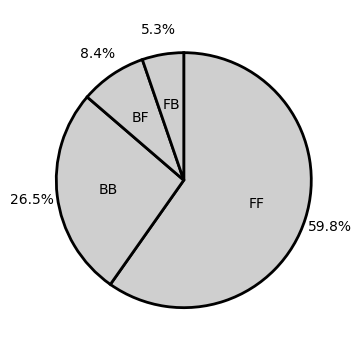

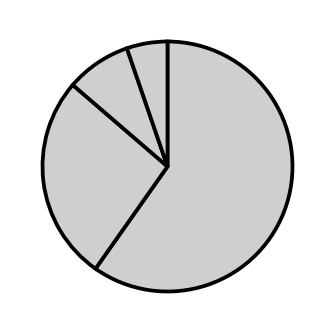

In [ ]:
fb_group = np.array([
    np.sum((forward_backward_frame[tOmega_start_frame_block]==1)*(forward_backward_frame[tOmega_end_frame_block]==1)), \
    np.sum((forward_backward_frame[tOmega_start_frame_block]==-1)*(forward_backward_frame[tOmega_end_frame_block]==-1)), \
    np.sum((forward_backward_frame[tOmega_start_frame_block]==-1)*(forward_backward_frame[tOmega_end_frame_block]==1)), \
    np.sum((forward_backward_frame[tOmega_start_frame_block]==1)*(forward_backward_frame[tOmega_end_frame_block]==-1)) \
]) # FF, BB, BF, FB
# For reference
fig, ax = plt.subplots(1, 1, figsize=(3.5, 3.5), constrained_layout=True)
ax.pie(
    fb_group,
    labels=np.array(['FF', 'BB', 'BF', 'FB']),
    counterclock=False,
    startangle=90,
    autopct='%1.1f%%',
    textprops=dict(ha='center'),
    labeldistance=0.6,
    pctdistance=1.2,
    colors=[light_grey]*len(fb_group),
    wedgeprops={'edgecolor': 'black', 'linewidth': 2}
)
ax.axis('equal')
plt.show()
# For save
fig, ax = plt.subplots(1, 1, figsize=(1, 1), constrained_layout=True, dpi=300)
ax.pie(
    fb_group,
    counterclock=False,
    startangle=90,
    colors=[light_grey]*len(fb_group),
    wedgeprops={'edgecolor': 'black', 'linewidth': 0.9}
)
fig.savefig(os.path.join(save_fig_dir, '3-G-Ratio_of_each_type_of_turn.svg'), format="svg", transparent=True)
ax.axis('equal')
plt.show()

## Figure 3H

In [ ]:
# 各シーケンスをタプルに変換し、Counterで種類と数をカウント
sequence_counter = Counter(tuple(array) for array in tOmega_label_sOmega)

# 結果の表示
for sequence, count in sequence_counter.most_common():
    print(f"Sequence {sequence}: {count} times")

Sequence (np.float64(1.0),): 702 times
Sequence (np.float64(4.0), np.float64(1.0)): 102 times
Sequence (np.float64(4.0),): 101 times
Sequence (np.float64(1.0), np.float64(1.0)): 97 times
Sequence (np.float64(3.0),): 73 times
Sequence (np.float64(2.0),): 25 times
Sequence (np.float64(4.0), np.float64(4.0)): 24 times
Sequence (np.float64(4.0), np.float64(4.0), np.float64(1.0)): 24 times
Sequence (np.float64(2.0), np.float64(1.0)): 19 times
Sequence (np.float64(1.0), np.float64(1.0), np.float64(1.0)): 18 times
Sequence (np.float64(3.0), np.float64(1.0)): 18 times
Sequence (np.float64(4.0), np.float64(3.0)): 17 times
Sequence (np.float64(1.0), np.float64(4.0), np.float64(1.0)): 16 times
Sequence (np.float64(1.0), np.float64(3.0)): 13 times
Sequence (np.float64(4.0), np.float64(1.0), np.float64(1.0)): 10 times
Sequence (np.float64(2.0), np.float64(3.0)): 8 times
Sequence (np.float64(1.0), np.float64(4.0)): 8 times
Sequence (np.float64(4.0), np.float64(4.0), np.float64(4.0), np.float64(1.0))

In [ ]:
top_5_sequences = np.array(sequence_counter.most_common(5), dtype=object)
print(top_5_sequences)

[[(np.float64(1.0),) 702]
 [(np.float64(4.0), np.float64(1.0)) 102]
 [(np.float64(4.0),) 101]
 [(np.float64(1.0), np.float64(1.0)) 97]
 [(np.float64(3.0),) 73]]


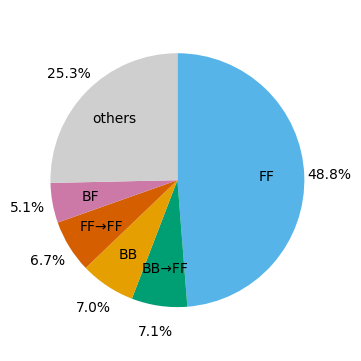

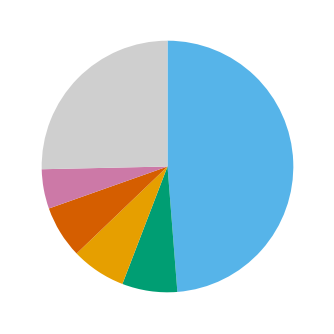

In [ ]:
custom_order = [1, 2, 4, 5, 6]
reordered_palette = [color_palette[i] for i in custom_order]
reordered_palette.append(light_grey)

fb_group = np.array([702, 102, 101, 97, 73, sOmega_num-702-102-101-97-73])
# F, BF, B, FF, BF
# For reference
fig, ax = plt.subplots(1, 1, figsize=(3.5, 3.5), constrained_layout=True)
ax.pie(
    fb_group,
    labels=np.array(['FF', 'BB→FF', 'BB', 'FF→FF', 'BF', 'others']),
    counterclock=False,
    startangle=90,
    autopct='%1.1f%%',
    textprops=dict(ha='center'),
    labeldistance=0.7,
    pctdistance=1.2,
    colors=reordered_palette
)
ax.axis('equal')
plt.show()
# For save
fig, ax = plt.subplots(1, 1, figsize=(1, 1), constrained_layout=True, dpi=300)
ax.pie(
    fb_group,
    counterclock=False,
    startangle=90,
    colors=reordered_palette
)
ax.axis('equal')
fig.savefig(os.path.join(save_fig_dir, f'3-H-ratio_of_sequence_types.svg'), format="svg", transparent=True)
plt.show()

## Figure 3I left

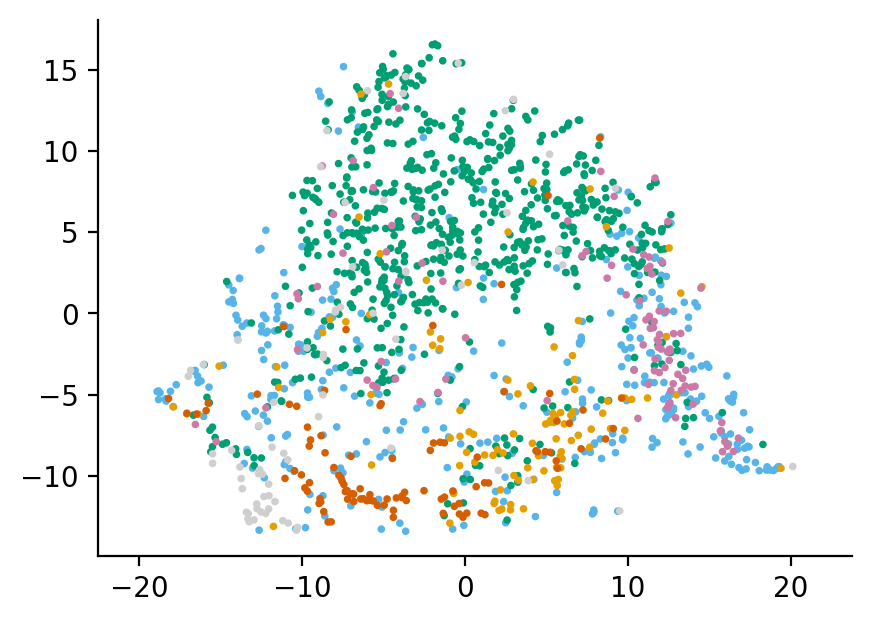

In [ ]:
cmap = ListedColormap(reordered_palette, name="custom")
fig, ax = plt.subplots(1, 1, figsize=(3*np.sqrt(2), 3), constrained_layout=True, dpi=200)
plot_data1 = TSNE_PC[:, 0]
plot_data2 = TSNE_PC[:, 1]
markers = ['o', ]
for i in range(6):
    plot_idx_i = np.argwhere(group_sOmega==i).reshape(-1)
    plt.scatter(plot_data1[plot_idx_i], plot_data2[plot_idx_i], marker="o", s=3, vmin=0, vmax=5,
                c=group_sOmega[plot_idx_i], cmap=cmap)
ax.axis('equal')
ax.set_xlim(ax.get_xlim()[0], ax.get_xlim()[1])

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
x_lims = ax.get_xlim()
y_lims = ax.get_ylim()
fig.savefig(os.path.join(save_fig_dir, f'3-I-left-t-SNE_map_colored_by_sequence_types.svg'), format="svg", transparent=True)
plt.show()

## Figure 3I right

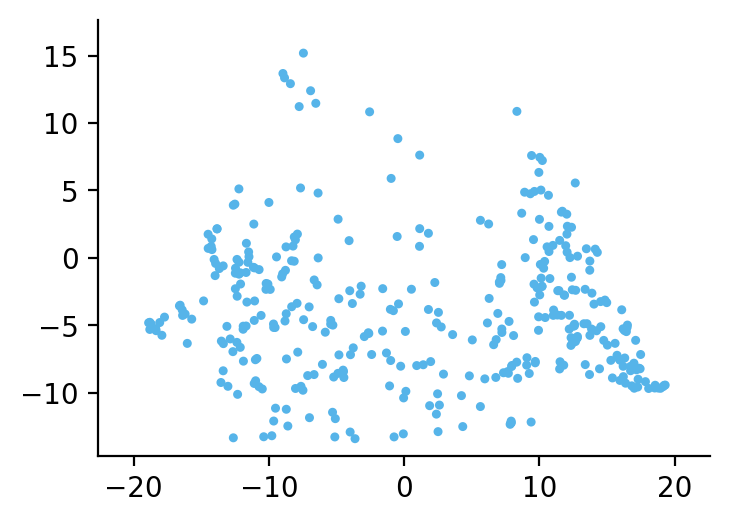

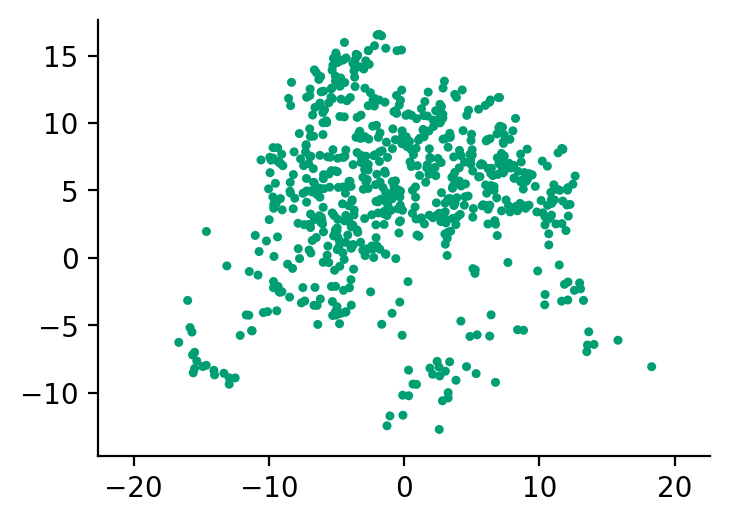

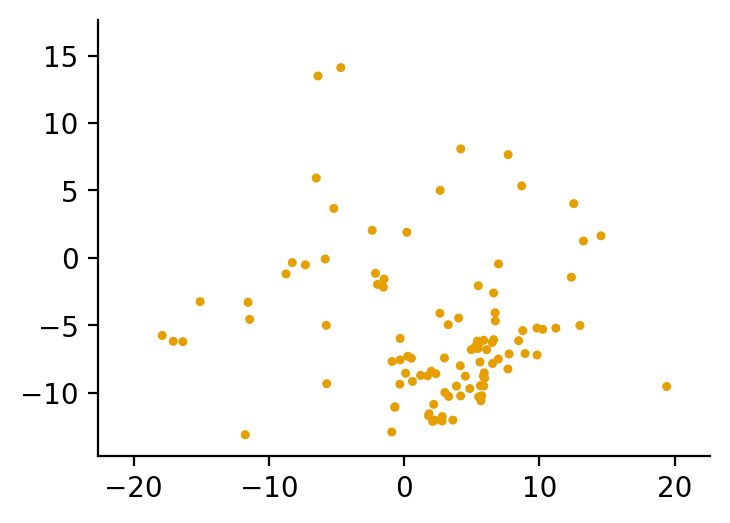

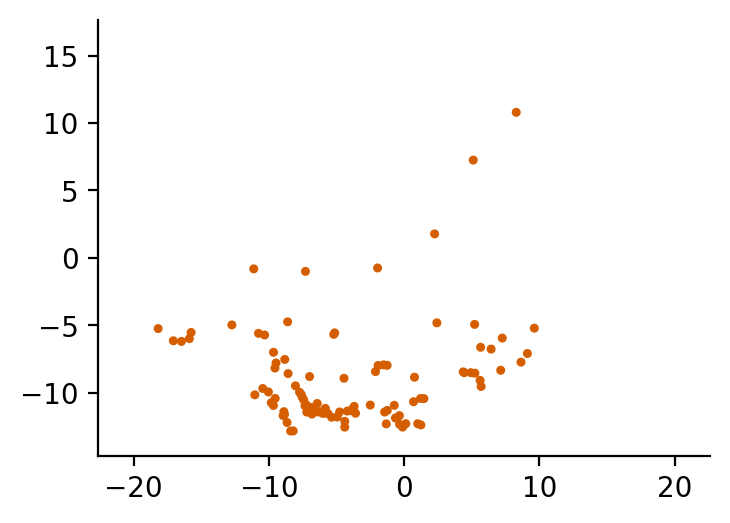

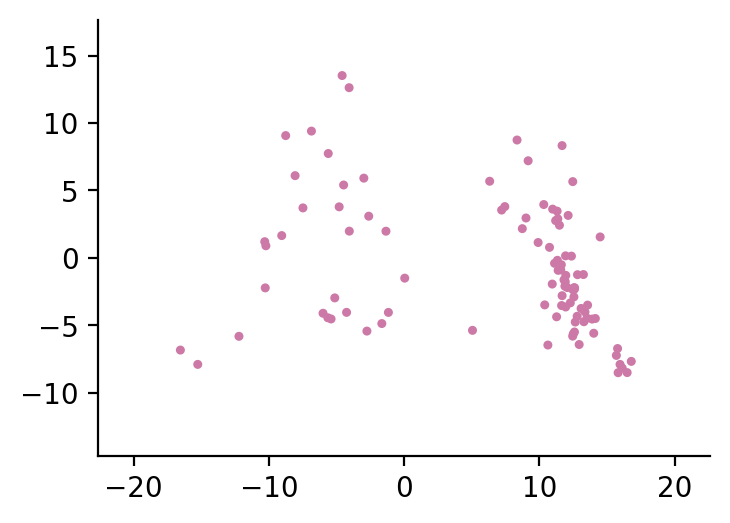

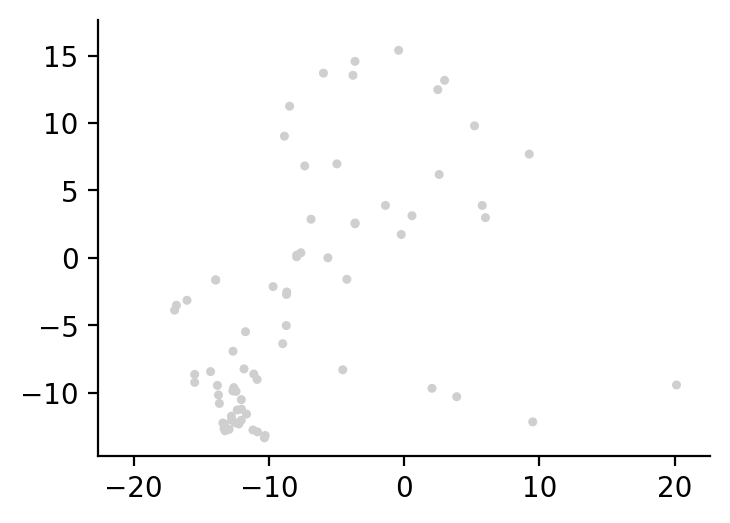

In [ ]:
cmap = ListedColormap(reordered_palette, name="custom")
plot_data1 = TSNE_PC[:, 0]
plot_data2 = TSNE_PC[:, 1]
figure_label_lists = ['Others', 'F', 'B_to_F', 'B', 'F_to_F', 'BF']
for i in range(6):
    fig, ax = plt.subplots(1, 1, figsize=(2.5*np.sqrt(2), 2.5), constrained_layout=True, dpi=200)
    plot_idx_i = np.argwhere(group_sOmega==i).reshape(-1)
    plt.scatter(plot_data1[plot_idx_i], plot_data2[plot_idx_i], marker="o", s=5, vmin=0, vmax=5,
                c=group_sOmega[plot_idx_i], cmap=cmap)
    ax.axis('equal')

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xlim(-23, 23)
    ax.set_ylim(-17, 20)
    fig.savefig(os.path.join(save_fig_dir, f'3-I-right-t-SNE_map_{figure_label_lists[i]}.svg'), format="svg", transparent=True)
    plt.show()

## Figure 4A

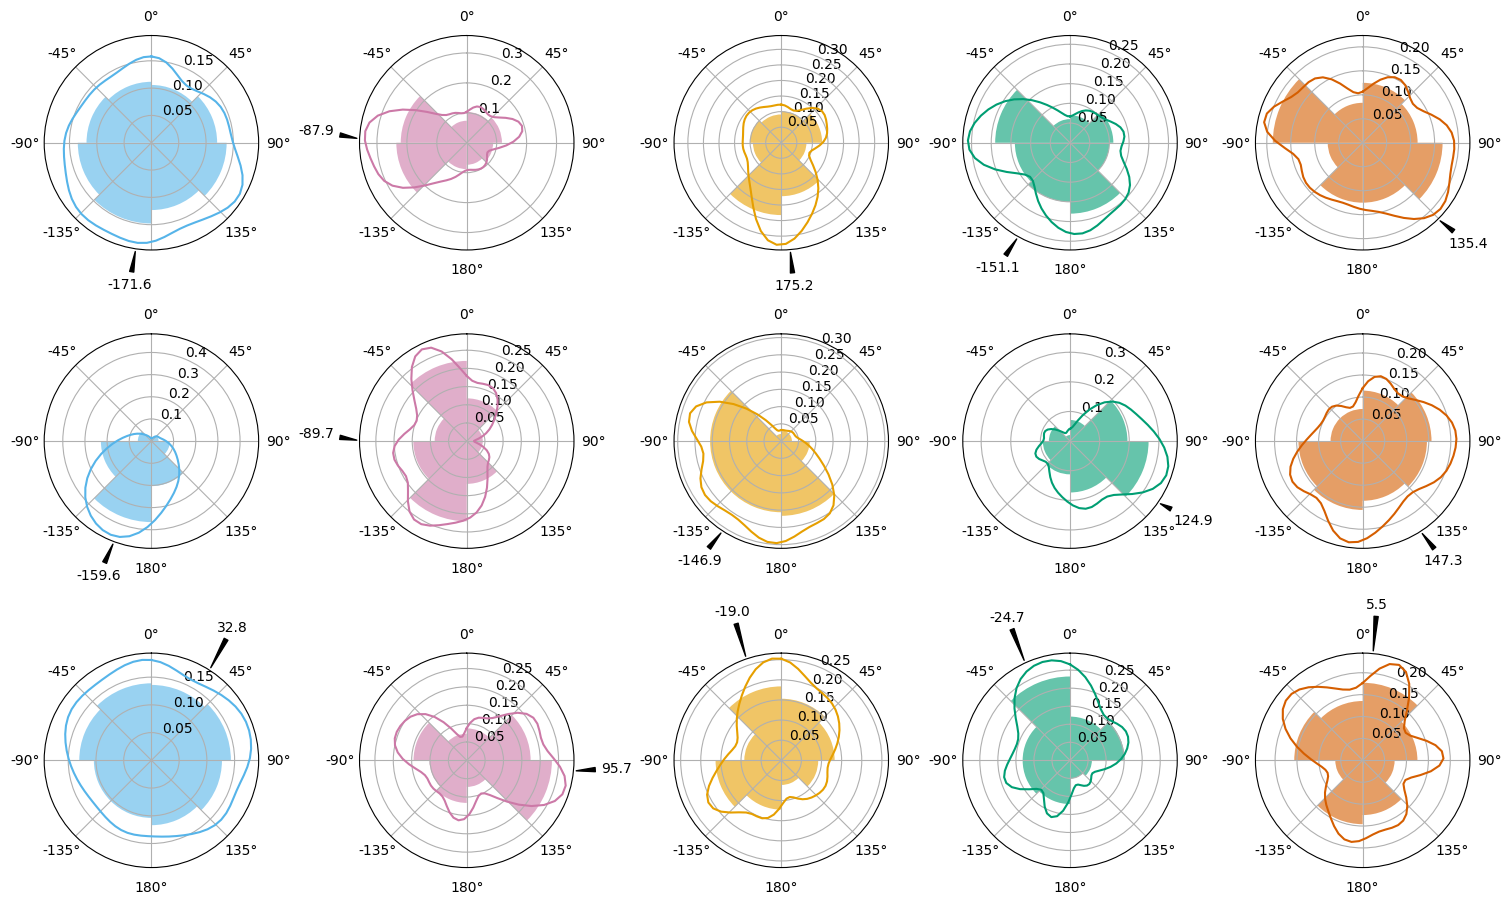

In [ ]:
bins_num = 8
bin_ends = np.linspace(0, 360, bins_num+1)
x_tick_labels = np.linspace(0, 360, bins_num+1)[:-1]
x_tick_labels[x_tick_labels>180] = x_tick_labels[x_tick_labels>180] - 360
fig, axes = plt.subplots(3, 5, figsize=(3*5, 3*3), constrained_layout=True, subplot_kw={'projection': 'polar'})
for i in range(5):
    idx_i = np.argwhere(group_sOmega==group_index[i]).reshape(-1)
    before_i = before_bearing_sOmega[idx_i]
    after_i = after_bearing_sOmega[idx_i]
    delta_i = after_i - before_i
    delta_i = (delta_i+180)%360 - 180
    delta_i = delta_i[~np.isnan(delta_i)]
    before_i = before_i[~np.isnan(before_i)]
    after_i = after_i[~np.isnan(after_i)]
    for j in range(3):
        ax = axes[j, i]
        if j ==0:
            data = before_i
        elif j==1:
            data = delta_i
        elif j==2:
            data = after_i
        data_i_pos = data.copy()
        data_i_pos[data_i_pos<0] = data_i_pos[data_i_pos<0] + 360
        counts, _ = np.histogram(data_i_pos, bins=bin_ends)
        counts_total = len(data)
        ax.bar(np.radians(bin_ends[:-1]), counts/counts_total, align='edge', width=2*np.pi/bins_num, color=rotation_ordered_palette[i], alpha=0.6)
        # plot kernel density estimates
        x, kde = vonmises_kde(np.radians(data), 15)
        ax.plot(x, kde, color=rotation_ordered_palette[i])
        # annotate mean angle
        mean_text = np.arctan2(np.nansum(np.sin(data*np.pi/180)), np.nansum(np.cos(data*np.pi/180))) * 180/np.pi
        if mean_text<0:
            mean = mean_text + 360
        else:
            mean = mean_text
        ax.annotate(f'{mean_text:.1f}', xy=(np.radians(mean), ax.get_ylim()[1]*1), xytext=(np.radians(mean), ax.get_ylim()[1]*1.4),
                    arrowprops=dict(facecolor='k', arrowstyle='wedge'), ha='center', va='bottom')
        # setting
        ax.set_theta_zero_location('N')
        ax.set_theta_direction(-1)
        ax.set_xticks(np.radians(bin_ends[:-1]))
        if (i==0)*(j==0):
            ax.set_xticklabels([f"{int(b)}°" if int(b) != 180 else "" for b in x_tick_labels])
        elif ((i==1)*(j==0)) + ((i==1)*(j==1)):
            ax.set_xticklabels([f"{int(b)}°" if int(b) != -90 else "" for b in x_tick_labels])
        elif (i==1)*(j==2):
            ax.set_xticklabels([f"{int(b)}°" if int(b) != 90 else "" for b in x_tick_labels])
        elif (i==2)*(j==0):
            ax.set_xticklabels([f"{int(b)}°" if int(b) != 180 else "" for b in x_tick_labels])
        elif (i==4)*(j==0):
            ax.set_xticklabels([f"{int(b)}°" if int(b) != 135 else "" for b in x_tick_labels])
        else:
            ax.set_xticklabels([f"{int(b)}°" for b in x_tick_labels])
fig.savefig(os.path.join(save_fig_dir, f'4-A-bearing_distribution_of_each_sequence_type.svg'), format="svg", transparent=True)
plt.show()

## Figure 4B

Contingency Table (ビン×タイプ):
[[150  12  19  13  20]
 [178  14  21  21  27]
 [187  11  40  33  24]
 [175  31  19  33  25]]
カイ二乗統計量: 29.195
自由度: 12
p値: 0.0037


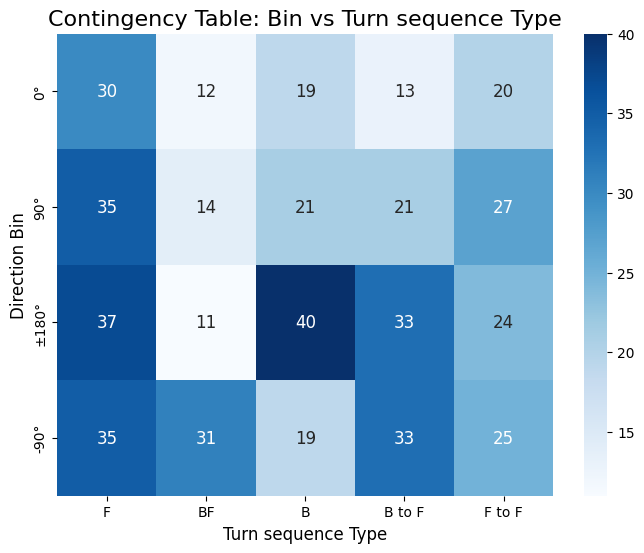

In [ ]:
def assign_bin(angle_deg):
    if -45 <= angle_deg < 45:
        return 0  # Bin 0°
    elif 45 <= angle_deg < 135:
        return 1  # Bin 90°
    elif (135 <= angle_deg <= 180) or (-180 <= angle_deg < -135):
        return 2  # Bin 180°
    elif -135 <= angle_deg < -45:
        return 3  # Bin 270°

contingency_table = np.zeros((4, 5), dtype=int)

for i in range(5):
    idx_i = np.argwhere(group_sOmega == group_index[i]).reshape(-1)
    before_i = before_bearing_sOmega[idx_i]
    before_i = before_i[~np.isnan(before_i)]
    for angle in before_i:
        bin_id = assign_bin(angle)
        contingency_table[bin_id, i] += 1

print("Contingency Table (ビン×タイプ):")
print(contingency_table)

chi2, p, dof, expected = chi2_contingency(contingency_table)
print(f"カイ二乗統計量: {chi2:.3f}")
print(f"自由度: {dof}")
print(f"p値: {p:.4f}")

contingency_table_2 = contingency_table.copy()
contingency_table_2[:, 0] = contingency_table[:, 0]/5
contingency_df = pd.DataFrame(contingency_table_2, columns=[group_names],
                                index=['0°', '90°', '±180°', '-90°'])

plt.figure(figsize=(8, 6))
sns.heatmap(contingency_df, annot=True, fmt='d', cmap='Blues', cbar=True, annot_kws={"size": 12})

plt.title('Contingency Table: Bin vs Turn sequence Type', fontsize=16)
plt.xlabel('Turn sequence Type', fontsize=12)
plt.ylabel('Direction Bin', fontsize=12)
fig.savefig(os.path.join(save_fig_dir, f'4-B-contingency_table_each_sequence_type.svg'), format="svg", transparent=True)
plt.show()

## Figure 4C
(with new random data)

F
turn type: 1, rand_mean: 0.039534278676077186, rand_std: 0.021397159642181276, z: 0.9519009071680148, permu_p: 0.17057361971889518


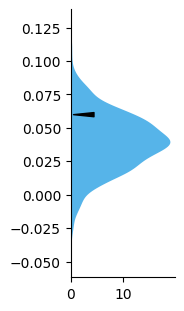

BF
turn type: 2, rand_mean: -0.06040063217070388, rand_std: 0.08294498776527523, z: 0.6044954316484253, permu_p: 0.27275715277567536


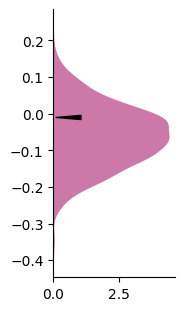

B
turn type: 3, rand_mean: 0.07496525631182564, rand_std: 0.06426256981426902, z: 0.7180298174960209, permu_p: 0.23636945094321993


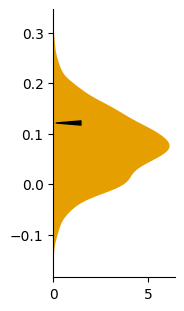

B to F
turn type: 4, rand_mean: 0.07008679726661711, rand_std: 0.06539968958451325, z: 2.2103858004937376, permu_p: 0.013539199213027042


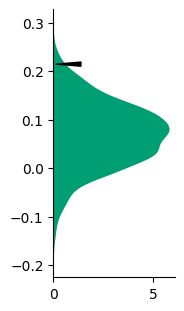

F to F
turn type: 5, rand_mean: 0.0007763435379421845, rand_std: 0.07350235697573393, z: 0.991990359503204, permu_p: 0.16060111409865363


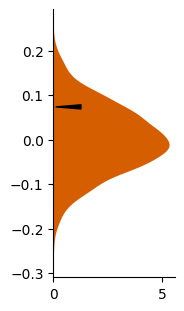

In [ ]:
sampling_num = 1000
bins_num = 8
bin_ends = np.linspace(-180, 180, bins_num+1)
figure_label_lists = ['F', 'BF', 'B', 'B_to_F', 'F_to_F']

for i in range(len(group_names)):
    print(group_names[i])
    randomized_bAfter = np.array([])
    randomized_p = []
    idx_i = np.argwhere(group_sOmega==group_index[i]).reshape(-1) # group_index: 1, 5, 3, 2, 4
    before_i = before_bearing_sOmega[idx_i]
    after_i = after_bearing_sOmega[idx_i]
    delta_i = after_i - before_i
    delta_i = (delta_i+180)%360 - 180
    after_i = after_i[~np.isnan(after_i)]
    obs_p = np.mean(np.cos(np.deg2rad(after_i)))
    for _ in range(sampling_num):
        shuffled_id = np.random.choice(a=len(delta_i), size=len(before_i), replace=False)
        not_nan_idx_i = np.argwhere((~np.isnan(before_i))*(~np.isnan(delta_i[shuffled_id]))).reshape(-1)
        randomized_bAfter_i = before_i + delta_i[shuffled_id]
        randomized_bAfter_i = randomized_bAfter_i[not_nan_idx_i]
        randomized_bAfter_i = randomized_bAfter_i[~np.isnan(randomized_bAfter_i)]
        randomized_bAfter_i = (randomized_bAfter_i+180)%(360) - 180
        rand_p_i = np.mean(np.cos(np.deg2rad(randomized_bAfter_i)))
        randomized_p.append(rand_p_i)
        randomized_bAfter = np.concatenate([randomized_bAfter, randomized_bAfter_i], axis=0)
    randomized_p = np.array(randomized_p)
    rand_mean = np.mean(randomized_p)
    rand_std = np.std(randomized_p, ddof=1)
    rand_error = rand_std / np.sqrt(len(randomized_p))
    z = (obs_p - rand_mean) / rand_std
    permu_p = stats.norm.cdf(z)
    if permu_p>0.5:
        permu_p = 1 - permu_p
    print(f'turn type: {i+1}, rand_mean: {rand_mean}, rand_std: {rand_std}, z: {z}, permu_p: {permu_p}')

    df = pd.DataFrame({
        'rand_good': randomized_p
    })
    fig, ax = plt.subplots(1, 1, figsize=(3/np.sqrt(3), 3), constrained_layout=True)
    sns.kdeplot(data=df, y='rand_good', ax=ax, clip_on=False, fill=True, alpha=1, linewidth=0, color=rotation_ordered_palette[i])
    ax.annotate(f'', xy=(0, obs_p), xytext=(ax.get_xlim()[1]*0.25, obs_p),
                arrowprops=dict(facecolor='k', edgecolor='k', arrowstyle='wedge'), ha='left', va='center')
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    fig.savefig(os.path.join(save_fig_dir, f'4-C-intra_type_randomization_{figure_label_lists[i]}.svg'), format="svg", transparent=True)
    plt.show()

## Figure 4D
(with new random data)

F
turn type: 1, rand_mean: 0.009173312560836214, rand_std: 0.027500331767493707, z: 1.8446665377839344, permu_p: 0.032543030694753394


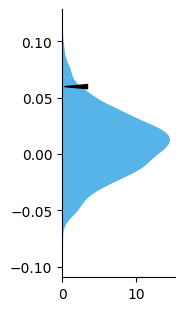

BF
turn type: 2, rand_mean: -0.025654680314405213, rand_std: 0.08107517147312017, z: 0.18987211554709418, permu_p: 0.4247046717660804


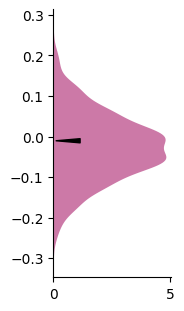

B
turn type: 3, rand_mean: 0.060655737347077875, rand_std: 0.06590093088660075, z: 0.9173157256964332, permu_p: 0.17948860960887414


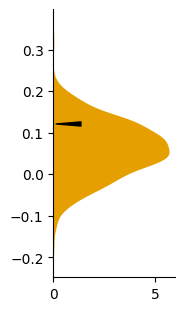

B to F
turn type: 4, rand_mean: 0.041322032700845376, rand_std: 0.06573689435881483, z: 2.636621511719418, permu_p: 0.004186810188457124


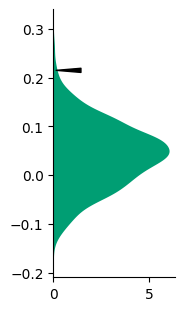

F to F
turn type: 5, rand_mean: 0.014345939812669881, rand_std: 0.0684615407148661, z: 0.8668229289948944, permu_p: 0.19301951846514176


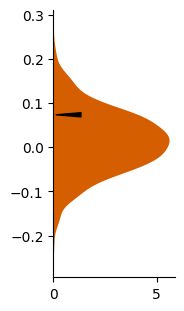

In [ ]:
sampling_num = 1000
bins_num = 8
bin_ends = np.linspace(-180, 180, bins_num+1)
figure_label_lists = ['F', 'BF', 'B', 'B_to_F', 'F_to_F']

for i in range(len(group_names)):
    print(group_names[i])
    randomized_bAfter = np.array([])
    randomized_p = []
    idx_i = np.argwhere(group_sOmega==group_index[i]).reshape(-1)
    before_i = before_bearing_sOmega[idx_i]
    after_i = after_bearing_sOmega[idx_i]
    delta_i = after_i - before_i
    delta_i = (delta_i+180)%360 - 180
    after_i = after_i[~np.isnan(after_i)]
    obs_p = np.mean(np.cos(np.deg2rad(after_i)))
    idx_o = np.argwhere(group_sOmega!=group_index[i]).reshape(-1)
    before_o = before_bearing_sOmega[idx_o]
    after_o = after_bearing_sOmega[idx_o]
    delta_o = after_o - before_o
    delta_o = (delta_o+180)%360 - 180
    for _ in range(sampling_num):
        shuffled_id = np.random.choice(a=len(delta_o), size=len(before_i), replace=False)
        not_nan_idx_i = np.argwhere((~np.isnan(before_i))*(~np.isnan(delta_o[shuffled_id]))).reshape(-1)
        randomized_bAfter_i = before_i + delta_o[shuffled_id]
        randomized_bAfter_i = randomized_bAfter_i[not_nan_idx_i]
        randomized_bAfter_i = randomized_bAfter_i[~np.isnan(randomized_bAfter_i)]
        randomized_bAfter_i = (randomized_bAfter_i+180)%(360) - 180
        rand_p_i = np.mean(np.cos(np.deg2rad(randomized_bAfter_i)))
        randomized_p.append(rand_p_i)
        randomized_bAfter = np.concatenate([randomized_bAfter, randomized_bAfter_i], axis=0)
    randomized_p = np.array(randomized_p)
    rand_mean = np.mean(randomized_p)
    rand_std = np.std(randomized_p, ddof=1)
    rand_error = rand_std / np.sqrt(len(randomized_p))
    z = (obs_p - rand_mean) / rand_std
    permu_p = stats.norm.cdf(z)
    if permu_p>0.5:
        permu_p = 1 - permu_p
    print(f'turn type: {i+1}, rand_mean: {rand_mean}, rand_std: {rand_std}, z: {z}, permu_p: {permu_p}')

    df = pd.DataFrame({
        'rand_good': randomized_p
    })
    fig, ax = plt.subplots(1, 1, figsize=(3/np.sqrt(3), 3), constrained_layout=True)
    sns.kdeplot(data=df, y='rand_good', ax=ax, clip_on=False, fill=True, alpha=1, linewidth=0, color=rotation_ordered_palette[i])
    ax.annotate(f'', xy=(0, obs_p), xytext=(ax.get_xlim()[1]*0.25, obs_p),
                arrowprops=dict(facecolor='k', edgecolor='k', arrowstyle='wedge'), ha='left', va='center') # "#E60080"
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    fig.savefig(os.path.join(save_fig_dir, f'4-D-inter_type_randomization_{figure_label_lists[i]}.svg'), format="svg", transparent=True)
    plt.show()

## Figure 4E
(with new random data)

rand_mean: 0.027388838812413243, rand_std: 0.013381813863965433, z: 2.037717612709325, permu_p: 0.02078909087717351


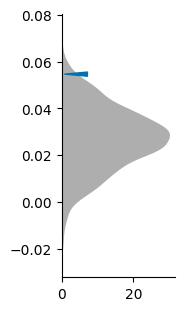

In [ ]:
sampling_num = 1000
bins_num = 8
bin_ends = np.linspace(-180, 180, bins_num+1)
bAfter = after_bearing_sOmega
bAfter = bAfter[~np.isnan(bAfter)]
bAfter_others = after_bearing_sOmega[np.argwhere((group_sOmega!=1)*(group_sOmega!=3)*(group_sOmega!=5)).reshape(-1)]
bAfter_others = bAfter_others[~np.isnan(bAfter_others)]

randomized_bAfter = np.array([])
randomized_p = []
for j in range(sampling_num):
    randomized_bAfter_j = np.array([])
    for i in range(3):
        idx_i = np.argwhere(group_sOmega==2*i+1).reshape(-1)
        before_i = before_bearing_sOmega[idx_i]
        after_i = after_bearing_sOmega[idx_i]
        delta_i = after_i - before_i
        delta_i = (delta_i+180)%360 - 180
        idx_o = np.argwhere((group_sOmega!=2*i+1)*((group_sOmega==1)+(group_sOmega==3)+(group_sOmega==5))).reshape(-1)
        before_o = before_bearing_sOmega[idx_o]
        after_o = after_bearing_sOmega[idx_o]
        delta_o = after_o - before_o
        delta_o = (delta_o+180)%360 - 180
        shuffled_id = np.random.choice(a=len(delta_o), size=len(before_i), replace=True)
        not_nan_idx_i = np.argwhere((~np.isnan(before_i))*(~np.isnan(delta_o[shuffled_id]))).reshape(-1)
        randomized_bAfter_i = before_i + delta_o[shuffled_id]
        randomized_bAfter_i = randomized_bAfter_i[not_nan_idx_i]
        randomized_bAfter_i = randomized_bAfter_i[~np.isnan(randomized_bAfter_i)]
        randomized_bAfter_i = (randomized_bAfter_i+180)%(360) - 180
        randomized_bAfter_j = np.concatenate([randomized_bAfter_j, randomized_bAfter_i], axis=0)
    randomized_bAfter_j = np.concatenate([randomized_bAfter_j, bAfter_others], axis=0)
    randomized_bAfter = np.concatenate([randomized_bAfter, randomized_bAfter_j], axis=0)
    rand_p_i = np.mean(np.cos(np.deg2rad(randomized_bAfter_j)))
    randomized_p.append(rand_p_i)
randomized_p = np.array(randomized_p)
obs_p = np.mean(np.cos(np.deg2rad(bAfter)))
rand_mean = np.mean(randomized_p)
rand_std = np.std(randomized_p, ddof=1)
rand_error = rand_std / np.sqrt(len(randomized_p))
z = (obs_p - rand_mean) / rand_std
permu_p = stats.norm.cdf(z)
if permu_p>0.5:
    permu_p = 1 - permu_p
print(f'rand_mean: {rand_mean}, rand_std: {rand_std}, z: {z}, permu_p: {permu_p}')

df = pd.DataFrame({
    'rand_good': randomized_p
})
fig, ax = plt.subplots(1, 1, figsize=(3/np.sqrt(3), 3), constrained_layout=True)
sns.kdeplot(data=df, y='rand_good', ax=ax, clip_on=False, fill=True, alpha=0.6, linewidth=0, color=grey)
ax.annotate(f'', xy=(0, obs_p), xytext=(ax.get_xlim()[1]*0.25, obs_p),
            arrowprops=dict(facecolor=blue, edgecolor=blue, arrowstyle='wedge'), ha='left', va='center')
ax.set_xlabel('')
ax.set_ylabel('')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
fig.savefig(os.path.join(save_fig_dir, f'4-E-inter_singe_turns_randomization.svg'), format="svg", transparent=True)
plt.show()

## Figure 4F
(with new random data)

rand_mean: 0.03922681160563621, rand_std: 0.01182658712772905, z: 1.304720021146132, permu_p: 0.09599410073296344


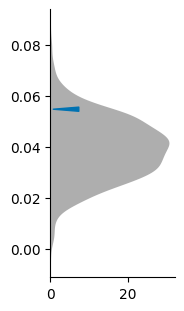

In [ ]:
sampling_num = 1000
bins_num = 8
bin_ends = np.linspace(-180, 180, bins_num+1)
bAfter = after_bearing_sOmega
bAfter = bAfter[~np.isnan(bAfter)]
bAfter_others = after_bearing_sOmega[np.argwhere((group_sOmega!=1)*(group_sOmega!=3)*(group_sOmega!=5)).reshape(-1)]
bAfter_others = bAfter_others[~np.isnan(bAfter_others)]

randomized_bAfter = np.array([])
randomized_p = []
for j in range(sampling_num):
    randomized_bAfter_j = np.array([])
    for i in range(3):
        idx_i = np.argwhere(group_sOmega==2*i+1).reshape(-1)
        before_i = before_bearing_sOmega[idx_i]
        after_i = after_bearing_sOmega[idx_i]
        delta_i = after_i - before_i
        delta_i = (delta_i+180)%360 - 180
        shuffled_id = np.random.choice(a=len(before_i), size=len(before_i), replace=True)
        not_nan_idx_i = np.argwhere((~np.isnan(before_i))*(~np.isnan(delta_i[shuffled_id]))).reshape(-1)
        randomized_bAfter_i = before_i + delta_i[shuffled_id]
        randomized_bAfter_i = randomized_bAfter_i[not_nan_idx_i]
        randomized_bAfter_i = randomized_bAfter_i[~np.isnan(randomized_bAfter_i)]
        randomized_bAfter_i = (randomized_bAfter_i+180)%(360) - 180
        randomized_bAfter_j = np.concatenate([randomized_bAfter_j, randomized_bAfter_i], axis=0)
    randomized_bAfter_j = np.concatenate([randomized_bAfter_j, bAfter_others], axis=0)
    randomized_bAfter = np.concatenate([randomized_bAfter, randomized_bAfter_j], axis=0)
    rand_p_i = np.mean(np.cos(np.deg2rad(randomized_bAfter_j)))
    randomized_p.append(rand_p_i)
randomized_p = np.array(randomized_p)
obs_p = np.mean(np.cos(np.deg2rad(bAfter)))
rand_mean = np.mean(randomized_p)
rand_std = np.std(randomized_p, ddof=1)
rand_error = rand_std / np.sqrt(len(randomized_p))
z = (obs_p - rand_mean) / rand_std
permu_p = stats.norm.cdf(z)
if permu_p>0.5:
    permu_p = 1 - permu_p
print(f'rand_mean: {rand_mean}, rand_std: {rand_std}, z: {z}, permu_p: {permu_p}')


df = pd.DataFrame({
    'rand_good': randomized_p
})
fig, ax = plt.subplots(1, 1, figsize=(3/np.sqrt(3), 3), constrained_layout=True)
sns.kdeplot(data=df, y='rand_good', ax=ax, clip_on=False, fill=True, alpha=0.6, linewidth=0, color=grey)
ax.annotate(f'', xy=(0, obs_p), xytext=(ax.get_xlim()[1]*0.25, obs_p),
            arrowprops=dict(facecolor=blue, edgecolor=blue, arrowstyle='wedge'), ha='left', va='center')
ax.set_xlabel('')
ax.set_ylabel('')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
fig.savefig(os.path.join(save_fig_dir, f'4-F-intra_singe_turns_randomization.svg'), format="svg", transparent=True)
plt.show()

## Figure 4G
(with new random data)

rand_mean: 0.014111376270029957, rand_std: 0.016318695187524, z: 2.4846239161315813, permu_p: 0.006484418169317441


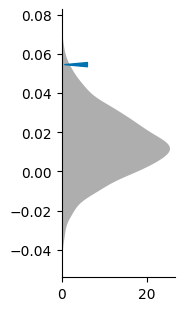

In [ ]:
sampling_num = 1000
bins_num = 8
bin_ends = np.linspace(-180, 180, bins_num+1)
bAfter = after_bearing_sOmega
bAfter = bAfter[~np.isnan(bAfter)]
bAfter_others = after_bearing_sOmega[np.argwhere((group_sOmega==0)).reshape(-1)]
bAfter_others = bAfter_others[~np.isnan(bAfter_others)]

randomized_bAfter = np.array([])
randomized_p = []
for j in range(sampling_num):
    randomized_bAfter_j = np.array([])
    for i in range(5):
        idx_i = np.argwhere(group_sOmega==i+1).reshape(-1)
        before_i = before_bearing_sOmega[idx_i]
        after_i = after_bearing_sOmega[idx_i]
        delta_i = after_i - before_i
        delta_i = (delta_i+180)%360 - 180
        idx_o = np.argwhere((group_sOmega!=i+1)*(group_sOmega!=0)).reshape(-1)
        before_o = before_bearing_sOmega[idx_o]
        after_o = after_bearing_sOmega[idx_o]
        delta_o = after_o - before_o
        delta_o = (delta_o+180)%360 - 180
        shuffled_id = np.random.choice(a=len(delta_o), size=len(before_i), replace=True)
        not_nan_idx_i = np.argwhere((~np.isnan(before_i))*(~np.isnan(delta_o[shuffled_id]))).reshape(-1)
        randomized_bAfter_i = before_i + delta_o[shuffled_id]
        randomized_bAfter_i = randomized_bAfter_i[not_nan_idx_i]
        randomized_bAfter_i = randomized_bAfter_i[~np.isnan(randomized_bAfter_i)]
        randomized_bAfter_i = (randomized_bAfter_i+180)%(360) - 180
        randomized_bAfter_j = np.concatenate([randomized_bAfter_j, randomized_bAfter_i], axis=0)
    randomized_bAfter_j = np.concatenate([randomized_bAfter_j, bAfter_others], axis=0)
    randomized_bAfter = np.concatenate([randomized_bAfter, randomized_bAfter_j], axis=0)
    rand_p_i = np.mean(np.cos(np.deg2rad(randomized_bAfter_j)))
    randomized_p.append(rand_p_i)
randomized_p = np.array(randomized_p)
obs_p = np.mean(np.cos(np.deg2rad(bAfter)))
rand_mean = np.mean(randomized_p)
rand_std = np.std(randomized_p, ddof=1)
rand_error = rand_std / np.sqrt(len(randomized_p))
z = (obs_p - rand_mean) / rand_std
permu_p = stats.norm.cdf(z)
if permu_p>0.5:
    permu_p = 1 - permu_p
print(f'rand_mean: {rand_mean}, rand_std: {rand_std}, z: {z}, permu_p: {permu_p}')


df = pd.DataFrame({
    'rand_good': randomized_p
})
fig, ax = plt.subplots(1, 1, figsize=(3/np.sqrt(3), 3), constrained_layout=True)
sns.kdeplot(data=df, y='rand_good', ax=ax, clip_on=False, fill=True, alpha=0.6, linewidth=0, color=grey)
ax.annotate(f'', xy=(0, obs_p), xytext=(ax.get_xlim()[1]*0.25, obs_p),
            arrowprops=dict(facecolor=blue, edgecolor=blue, arrowstyle='wedge'), ha='left', va='center')
ax.set_xlabel('')
ax.set_ylabel('')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
fig.savefig(os.path.join(save_fig_dir, f'4-G-inter_top5_randomization.svg'), format="svg", transparent=True)
plt.show()